In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score,accuracy_score
from sklearn.pipeline import Pipeline

In [761]:
pd.set_option('display.max_columns', None)
HospA_df=pd.read_csv("complete_dataset.csv")
HospA_df.head()

,Unnamed: 0,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,1.0,0.0
1,1,1.0,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,2.0,0.0
2,2,1.0,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,3.0,0.0
3,3,1.0,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,4.0,0.0
4,4,1.0,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,5.0,0.0


In [3]:
HospA_df=HospA_df.drop("Unnamed: 0",axis=1)

In [4]:
HospA_df.shape

(790215, 42)

In [5]:
HospA_df['SepsisLabel'].value_counts()

0.0    773079
1.0     17136
Name: SepsisLabel, dtype: int64

In [6]:
# Nan counts
HospA_df.isnull().sum()

patient_id               0
HR                   61189
O2Sat                95079
Temp                523314
SBP                 120201
MAP                  80858
DBP                 380297
Resp                 77258
EtCO2               790215
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
Age                      0
Gender                   0
U

In [7]:
# class proportion ratio
HospA_df['SepsisLabel'].value_counts()

0.0    773079
1.0     17136
Name: SepsisLabel, dtype: int64

### Training XGBoost after dropping feaures with more than 90% NaN and checking feature importance after shuffling each columns (on Hosp 1)

In [8]:
# Dropping those features which containing missing values equal or more than 90%
feature_lst=[]
HospA_df1=HospA_df.copy()
for feature in HospA_df.columns:
    if HospA_df[feature].isnull().sum()/len(HospA_df)>=0.90:
        feature_lst.append(feature)
        print(f"Dropping {feature} with {(HospA_df[feature].isnull().sum()/len(HospA_df))*100}% of missing values")
        print("-----------------------------------")
HospA_df1=HospA_df.drop(feature_lst,axis=1)

Dropping EtCO2 with 100.0% of missing values
-----------------------------------
Dropping HCO3 with 91.94940617426903% of missing values
-----------------------------------
Dropping PaCO2 with 91.23175338357282% of missing values
-----------------------------------
Dropping SaO2 with 95.04438665426498% of missing values
-----------------------------------
Dropping AST with 98.50420455192574% of missing values
-----------------------------------
Dropping BUN with 91.84070158121523% of missing values
-----------------------------------
Dropping Alkalinephos with 98.54065032934075% of missing values
-----------------------------------
Dropping Calcium with 95.02439209582202% of missing values
-----------------------------------
Dropping Chloride with 91.67606284365647% of missing values
-----------------------------------
Dropping Creatinine with 93.35788361395316% of missing values
-----------------------------------
Dropping Bilirubin_direct with 99.85042045519258% of missing values
---

In [9]:
HospA_df1.shape

(790215, 21)

In [10]:
HospA_df1.head()

,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,pH,Glucose,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,1.0,0.0
1,1.0,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,2.0,0.0
2,1.0,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,3.0,0.0
3,1.0,90.0,95.0,NaN,NaN,NaN,NaN,30.0,24.0,NaN,7.36,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,4.0,0.0
4,1.0,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,0.28,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,5.0,0.0


In [11]:
## Dropping HospAdmTime
HospA_df2=HospA_df1.drop(["HospAdmTime","patient_id"],axis=1)

In [12]:
HospA_df2.isnull().sum()

HR              61189
O2Sat           95079
Temp           523314
SBP            120201
MAP             80858
DBP            380297
Resp            77258
BaseExcess     707834
FiO2           678060
pH             699600
Glucose        693559
Potassium      704379
Hct            697157
Age                 0
Gender              0
Unit1          386165
Unit2          386165
ICULOS              0
SepsisLabel         0
dtype: int64

In [13]:
HospA_df2['Unit1'].value_counts(),HospA_df2['Unit2'].value_counts()

(1.0    204894
 0.0    199156
 Name: Unit1, dtype: int64,
 0.0    204894
 1.0    199156
 Name: Unit2, dtype: int64)

In [14]:
HospA_df2[HospA_df2['Unit1'].isnull()].isnull().sum()
# Unit1 and Unit2 have same number of nan in the same index

HR              34172
O2Sat           53982
Temp           273503
SBP             65670
MAP             42208
DBP            186497
Resp            38504
BaseExcess     353813
FiO2           333621
pH             352378
Glucose        349646
Potassium      347405
Hct            343681
Age                 0
Gender              0
Unit1          386165
Unit2          386165
ICULOS              0
SepsisLabel         0
dtype: int64

In [15]:
count=0
for i in range(len(HospA_df2)):
    if (HospA_df2.iloc[i,15]==0 and HospA_df2.iloc[i,16]==1) or (HospA_df2.iloc[i,15]==1 and HospA_df2.iloc[i,16]==0):
        count+=1
print("Count: ",count)
# Unit1 and Unit2 are similar columns as Unit1=0 means Unit2=1 and Unit1=1 means Unit2=0

Count:  404050


In [16]:
# So dropping any one of this features
HospA_df3=HospA_df2.drop("Unit2",axis=1)

In [17]:
X,y=HospA_df3.drop("SepsisLabel",axis=1),HospA_df3['SepsisLabel']

In [18]:
X.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'FiO2', 'pH', 'Glucose', 'Potassium', 'Hct', 'Age', 'Gender', 'Unit1',
       'ICULOS'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [21]:
y_train.value_counts(),y_test.value_counts()

(0.0    541155
 1.0     11995
 Name: SepsisLabel, dtype: int64,
 0.0    231924
 1.0      5141
 Name: SepsisLabel, dtype: int64)

In [22]:
pipe = Pipeline([('minmax', MinMaxScaler()), ('XG_Boost', xgb.XGBClassifier())], verbose = True)

In [23]:
# XGBoost class weights
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:49},
    y=y_train)

In [24]:
pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.1s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.1s


Pipeline(steps=[('minmax', MinMaxScaler()),
                ('XG_Boost',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))],
         verbose=True)

In [26]:
xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

0.844848459283319
[[196654  35270]
 [  1511   3630]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91    231924
         1.0       0.09      0.71      0.16      5141

    accuracy                           0.84    237065
   macro avg       0.54      0.78      0.54    237065
weighted avg       0.97      0.84      0.90    237065



In [50]:
def feature_imp_XGboost(feature_lst,X_test,pipe,y_test):
    performance_dict={}
    for i,feature in enumerate(feature_lst):
        a=pd.DataFrame(pipe.named_steps["minmax"].transform(X_test)).copy()
        b=a.copy()
        b[f'{i}_shuffle'] = np.random.permutation(b[i].values)
        a[i]=b[f'{i}_shuffle'].values
        shuffle_pred=pipe.named_steps["XG_Boost"].predict(a.values)
        performance_dict[feature]=[accuracy_score(y_test,shuffle_pred),
                                   precision_score(y_test,shuffle_pred),
                                   recall_score(y_test,shuffle_pred),
                                   f1_score(y_test,shuffle_pred)]
    df=pd.DataFrame.from_dict(performance_dict).T
    df.columns=['accuracy_score','precision_score','recall_score','f1_score']
    return df

In [51]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.839550,0.083194,0.638592,0.147210
O2Sat,0.844119,0.090956,0.687998,0.160670
Temp,0.841090,0.089099,0.686053,0.157716
SBP,0.833801,0.083761,0.670492,0.148918
MAP,0.823842,0.081600,0.694612,0.146044
DBP,0.842246,0.086883,0.659794,0.153547
Resp,0.843111,0.086937,0.656098,0.153531
BaseExcess,0.838601,0.089039,0.697919,0.157929
FiO2,0.838648,0.089532,0.702393,0.158820
pH,0.846582,0.093129,0.695195,0.164254


### Training XGBoost after dropping feaures with more than 90% NaN and checking feature importance after shuffling each columns (on Hosp1 and Hosp2)

In [52]:
HospB_df=pd.read_csv("complete_dataset(B).csv")
HospB_df.head()

,Unnamed: 0,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,1.0,0.0
1,1,1.0,93.0,92.5,NaN,110.0,76.0,56.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,2.0,0.0
2,2,1.0,91.0,96.0,NaN,108.0,84.5,72.0,23.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,3.0,0.0
3,3,1.0,93.0,98.0,NaN,123.0,87.0,61.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,4.0,0.0
4,4,1.0,93.0,95.0,NaN,110.0,81.0,70.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,5.0,0.0


In [53]:
HospB_df=HospB_df.drop(["Unnamed: 0"],axis=1)
HospB_df.shape

(761995, 42)

In [54]:
HospB_df['SepsisLabel'].value_counts()

0.0    751215
1.0     10780
Name: SepsisLabel, dtype: int64

In [55]:
### Merging hosp 1 and hosp 2
dataset_AB=pd.concat([HospA_df,HospB_df],ignore_index=True)

In [56]:
dataset_AB.head()

,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,1.0,0.0
1,1.0,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,2.0,0.0
2,1.0,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,3.0,0.0
3,1.0,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,4.0,0.0
4,1.0,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,5.0,0.0


In [57]:
dataset_AB.shape

(1552210, 42)

In [58]:
dataset_AB['SepsisLabel'].value_counts()

0.0    1524294
1.0      27916
Name: SepsisLabel, dtype: int64

In [679]:
27916/(27916+1524294)

0.01798467990800214

In [60]:
# Nan counts
dataset_AB.isnull().sum()

patient_id                0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets           1460001
Age                 

In [61]:
# Dropping those features which containing missing values equal or more than 90%
feature_lst=[]
dataset_AB1=dataset_AB.copy()
for feature in dataset_AB.columns:
    if dataset_AB[feature].isnull().sum()/len(dataset_AB)>=0.90:
        feature_lst.append(feature)
        print(f"Dropping {feature} with {(dataset_AB[feature].isnull().sum()/len(dataset_AB))*100}% of missing values")
        print("-----------------------------------")
dataset_AB1=dataset_AB.drop(feature_lst,axis=1)

Dropping EtCO2 with 96.2868426308296% of missing values
-----------------------------------
Dropping BaseExcess with 94.57901959142127% of missing values
-----------------------------------
Dropping HCO3 with 95.81061840859162% of missing values
-----------------------------------
Dropping FiO2 with 91.66575398947307% of missing values
-----------------------------------
Dropping pH with 93.06968773555124% of missing values
-----------------------------------
Dropping PaCO2 with 94.44012085993518% of missing values
-----------------------------------
Dropping SaO2 with 96.54937154122187% of missing values
-----------------------------------
Dropping AST with 98.37760354591197% of missing values
-----------------------------------
Dropping BUN with 93.13443412940259% of missing values
-----------------------------------
Dropping Alkalinephos with 98.39319421985428% of missing values
-----------------------------------
Dropping Calcium with 94.116066769316% of missing values
------------

In [62]:
dataset_AB1.shape

(1552210, 16)

In [63]:
dataset_AB1.head()

,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0.0,NaN,NaN,-0.03,1.0,0.0
1,1.0,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,83.14,0.0,NaN,NaN,-0.03,2.0,0.0
2,1.0,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,83.14,0.0,NaN,NaN,-0.03,3.0,0.0
3,1.0,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,83.14,0.0,NaN,NaN,-0.03,4.0,0.0
4,1.0,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,83.14,0.0,NaN,NaN,-0.03,5.0,0.0


In [64]:
dataset_AB2=dataset_AB1.drop(["patient_id","HospAdmTime","Unit2"],axis=1)
dataset_AB2.shape

(1552210, 13)

In [65]:
## Shuffling the records 
dataset_AB2 = dataset_AB2.sample(frac = 1)
dataset_AB2.shape

(1552210, 13)

In [66]:
X=dataset_AB2.drop("SepsisLabel",axis=1)
y=dataset_AB2['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [67]:
y_train.value_counts(),y_test.value_counts()

(0.0    1067006
 1.0      19541
 Name: SepsisLabel, dtype: int64,
 0.0    457288
 1.0      8375
 Name: SepsisLabel, dtype: int64)

In [68]:
# XGBoost
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:49},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  16.4s


Pipeline(steps=[('minmax', MinMaxScaler()),
                ('XG_Boost',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))],
         verbose=True)

In [76]:
xg_pred1=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred1))
print(confusion_matrix(y_test,xg_pred1))
print(classification_report(y_test,xg_pred1))

0.8570382443956251
[[393655  63633]
 [  2939   5436]]
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    457288
         1.0       0.08      0.65      0.14      8375

    accuracy                           0.86    465663
   macro avg       0.54      0.75      0.53    465663
weighted avg       0.98      0.86      0.91    465663



In [77]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.855441,0.071157,0.583881,0.126855
O2Sat,0.853611,0.075026,0.630209,0.134089
Temp,0.849172,0.072743,0.628776,0.130400
SBP,0.838926,0.069317,0.640239,0.125090
MAP,0.835944,0.068094,0.640239,0.123096
DBP,0.857236,0.074054,0.603104,0.131911
Resp,0.848534,0.072234,0.626627,0.129535
Glucose,0.856096,0.077879,0.645851,0.138997
Age,0.850310,0.063214,0.529910,0.112954
Gender,0.855136,0.076533,0.637493,0.136659


### Training XGBoost after dropping feaures with more than 90% NaN and checking feature importance after shuffling each columns (on Hosp2)

In [79]:
HospB_df['SepsisLabel'].value_counts()

0.0    751215
1.0     10780
Name: SepsisLabel, dtype: int64

In [680]:
10780/(10780+751215)

0.014147074455869133

In [80]:
HospB_df.isnull().sum()

patient_id               0
HR                   92210
O2Sat               107657
Temp                503670
SBP                 106064
MAP                 112412
DBP                 106257
Resp                161077
EtCO2               704359
BaseExcess          760231
HCO3                760584
FiO2                744785
pH                  745037
PaCO2               744982
SaO2                747594
AST                 748632
BUN                 719903
Alkalinephos        748586
Calcium             709982
Chloride            757306
Creatinine          719866
Bilirubin_direct    760187
Glucose             593135
Lactate             747692
Magnesium           725525
Phosphate           739590
Potassium           703306
Bilirubin_total     748547
TroponinI           748179
Hct                 717620
Hgb                 717225
PTT                 754602
WBC                 721896
Fibrinogen          757783
Platelets           721285
Age                      0
Gender                   0
U

In [81]:
# Dropping those features which containing missing values equal or more than 90%
feature_lst=[]
HospB_df1=HospB_df.copy()
for feature in HospB_df.columns:
    if HospB_df[feature].isnull().sum()/len(HospB_df)>=0.90:
        feature_lst.append(feature)
        print(f"Dropping {feature} with {(HospB_df[feature].isnull().sum()/len(HospB_df))*100}% of missing values")
        print("-----------------------------------")
HospB_df1=HospB_df.drop(feature_lst,axis=1)

Dropping EtCO2 with 92.43617084101602% of missing values
-----------------------------------
Dropping BaseExcess with 99.76850241799487% of missing values
-----------------------------------
Dropping HCO3 with 99.81482818128727% of missing values
-----------------------------------
Dropping FiO2 with 97.74145499642385% of missing values
-----------------------------------
Dropping pH with 97.77452607956745% of missing values
-----------------------------------
Dropping PaCO2 with 97.76730818443691% of missing values
-----------------------------------
Dropping SaO2 with 98.11009258590936% of missing values
-----------------------------------
Dropping AST with 98.24631395219129% of missing values
-----------------------------------
Dropping BUN with 94.47607923936509% of missing values
-----------------------------------
Dropping Alkalinephos with 98.24027716717302% of missing values
-----------------------------------
Dropping Calcium with 93.1741021922716% of missing values
----------

In [82]:
HospB_df1.head()

,patient_id,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1.0,1.0,0.0,-214.64,1.0,0.0
1,1.0,93.0,92.5,NaN,110.0,76.0,56.0,22.0,NaN,73.0,1.0,1.0,0.0,-214.64,2.0,0.0
2,1.0,91.0,96.0,NaN,108.0,84.5,72.0,23.5,233.0,73.0,1.0,1.0,0.0,-214.64,3.0,0.0
3,1.0,93.0,98.0,NaN,123.0,87.0,61.0,21.0,NaN,73.0,1.0,1.0,0.0,-214.64,4.0,0.0
4,1.0,93.0,95.0,NaN,110.0,81.0,70.0,20.0,NaN,73.0,1.0,1.0,0.0,-214.64,5.0,0.0


In [83]:
HospB_df2=HospB_df1.drop(["patient_id","HospAdmTime","Unit2"],axis=1)
HospB_df2.shape

(761995, 13)

In [84]:
X=HospB_df2.drop("SepsisLabel",axis=1)
y=HospB_df2['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [85]:
y_train.value_counts(),y_test.value_counts()

(0.0    525850
 1.0      7546
 Name: SepsisLabel, dtype: int64,
 0.0    225365
 1.0      3234
 Name: SepsisLabel, dtype: int64)

In [86]:
# XGBoost
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)
pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.1s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.4s


Pipeline(steps=[('minmax', MinMaxScaler()),
                ('XG_Boost',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))],
         verbose=True)

In [87]:
xg_pred2=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred2))
print(confusion_matrix(y_test,xg_pred2))
print(classification_report(y_test,xg_pred2))

0.7947410093657452
[[179409  45956]
 [   966   2268]]
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88    225365
         1.0       0.05      0.70      0.09      3234

    accuracy                           0.79    228599
   macro avg       0.52      0.75      0.49    228599
weighted avg       0.98      0.79      0.87    228599



In [88]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.818306,0.043634,0.566172,0.081023
O2Sat,0.784199,0.042443,0.661101,0.079764
Temp,0.783835,0.042663,0.666048,0.080189
SBP,0.823013,0.047966,0.610699,0.088946
MAP,0.819859,0.046968,0.608225,0.087201
DBP,0.829597,0.047436,0.578850,0.087686
Resp,0.797322,0.044361,0.648732,0.083043
Glucose,0.793416,0.046737,0.701299,0.087634
Age,0.786298,0.038111,0.581942,0.071537
Gender,0.791530,0.045304,0.684292,0.084981


### Trainging XGBoost on HospA which contains only cardinal feature where nan is represented as 1 and any value is 0

In [93]:
HospA_df.isnull().sum()
# dropping patient_id,HospAdmTime, EtCO2
# Age, Gender and ICULOS as those donot contain NaN
# As well as Unit1 and Unit2

patient_id               0
HR                   61189
O2Sat                95079
Temp                523314
SBP                 120201
MAP                  80858
DBP                 380297
Resp                 77258
EtCO2               790215
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
Age                      0
Gender                   0
U

In [762]:
HospA_df1=HospA_df.copy()
HospA_df1=HospA_df1.drop(['patient_id','Age','Gender','HospAdmTime','EtCO2','ICULOS','Unit1','Unit2'],axis=1)

In [763]:
## Replacing NaN with a high value i.e 100000
HospA_df2=HospA_df1.fillna(100000)

In [764]:
for f in HospA_df2.columns:
    if f != 'SepsisLabel':
        HospA_df2[f]=HospA_df2[f].apply(lambda x: 1 if x==100000 else 0)

In [765]:
for f in HospA_df2.columns:
    print(f,HospA_df2[f].unique())

Unnamed: 0 [0 1]
HR [1 0]
O2Sat [1 0]
Temp [1 0]
SBP [1 0]
MAP [1 0]
DBP [1 0]
Resp [1 0]
BaseExcess [1 0]
HCO3 [1 0]
FiO2 [1 0]
pH [1 0]
PaCO2 [1 0]
SaO2 [1 0]
AST [1 0]
BUN [1 0]
Alkalinephos [1 0]
Calcium [1 0]
Chloride [1 0]
Creatinine [1 0]
Bilirubin_direct [1 0]
Glucose [1 0]
Lactate [1 0]
Magnesium [1 0]
Phosphate [1 0]
Potassium [1 0]
Bilirubin_total [1 0]
TroponinI [1 0]
Hct [1 0]
Hgb [1 0]
PTT [1 0]
WBC [1 0]
Fibrinogen [1 0]
Platelets [1 0]
SepsisLabel [0. 1.]


In [766]:
X=HospA_df2.drop("SepsisLabel",axis=1)
y=HospA_df2['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [771]:
# pipe.named_steps['XG_Boost'].fit(X_train,y_train)
# y_pred=pipe.named_steps['XG_Boost'].predict(X_test)
# print(accuracy_score(y_test,y_pred))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))

0.9783013097673634
[[231920      4]
 [  5140      1]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    231924
         1.0       0.20      0.00      0.00      5141

    accuracy                           0.98    237065
   macro avg       0.59      0.50      0.49    237065
weighted avg       0.96      0.98      0.97    237065



In [773]:
# X_train=X_train.drop("Unnamed: 0",axis=1)
# X_test=X_test.drop("Unnamed: 0",axis=1)
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:49},
    y=y_train)
a=xgb.XGBClassifier()
a.fit(X_train,y_train,sample_weight=classes_weights)
y_pred=a.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.581439689536625
[[134798  97126]
 [  2100   3041]]
              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73    231924
         1.0       0.03      0.59      0.06      5141

    accuracy                           0.58    237065
   macro avg       0.51      0.59      0.39    237065
weighted avg       0.96      0.58      0.72    237065



### Trainging XGBoost on HospB which contains only cardinal feature where nan is represented as 1 and any value is 0

In [774]:
HospB_df.isnull().sum()
# dropping patient_id,HospAdmTime
# Age, Gender and ICULOS as those donot contain NaN
# As well as Unit1 and Unit2

patient_id               0
HR                   92210
O2Sat               107657
Temp                503670
SBP                 106064
MAP                 112412
DBP                 106257
Resp                161077
EtCO2               704359
BaseExcess          760231
HCO3                760584
FiO2                744785
pH                  745037
PaCO2               744982
SaO2                747594
AST                 748632
BUN                 719903
Alkalinephos        748586
Calcium             709982
Chloride            757306
Creatinine          719866
Bilirubin_direct    760187
Glucose             593135
Lactate             747692
Magnesium           725525
Phosphate           739590
Potassium           703306
Bilirubin_total     748547
TroponinI           748179
Hct                 717620
Hgb                 717225
PTT                 754602
WBC                 721896
Fibrinogen          757783
Platelets           721285
Age                      0
Gender                   0
U

In [775]:
HospB_df1=HospB_df.copy()
HospB_df1=HospB_df1.drop(['patient_id','Age','Gender','HospAdmTime','ICULOS','Unit1','Unit2'],axis=1)
## Replacing NaN with a high value i.e 100000
HospB_df2=HospB_df1.fillna(100000)
for f in HospB_df2.columns:
    if f != 'SepsisLabel':
        HospB_df2[f]=HospB_df2[f].apply(lambda x: 1 if x==100000 else 0)

for f in HospB_df2.columns:
    print(f,HospB_df2[f].unique())
    
X=HospB_df2.drop("SepsisLabel",axis=1)
y=HospB_df2['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# pipe.named_steps['XG_Boost'].fit(X_train,y_train)
# y_pred=pipe.named_steps['XG_Boost'].predict(X_test)
# print(accuracy_score(y_test,y_pred))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)
a=xgb.XGBClassifier()
a.fit(X_train,y_train,sample_weight=classes_weights)
y_pred=a.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

HR [1 0]
O2Sat [1 0]
Temp [1 0]
SBP [1 0]
MAP [1 0]
DBP [1 0]
Resp [1 0]
EtCO2 [1 0]
BaseExcess [1 0]
HCO3 [1 0]
FiO2 [1 0]
pH [1 0]
PaCO2 [1 0]
SaO2 [1 0]
AST [1 0]
BUN [1 0]
Alkalinephos [1 0]
Calcium [1 0]
Chloride [1 0]
Creatinine [1 0]
Bilirubin_direct [1 0]
Glucose [1 0]
Lactate [1 0]
Magnesium [1 0]
Phosphate [1 0]
Potassium [1 0]
Bilirubin_total [1 0]
TroponinI [1 0]
Hct [1 0]
Hgb [1 0]
PTT [1 0]
WBC [1 0]
Fibrinogen [1 0]
Platelets [1 0]
SepsisLabel [0. 1.]
0.4661218990459276
[[104376 120989]
 [  1055   2179]]
              precision    recall  f1-score   support

         0.0       0.99      0.46      0.63    225365
         1.0       0.02      0.67      0.03      3234

    accuracy                           0.47    228599
   macro avg       0.50      0.57      0.33    228599
weighted avg       0.98      0.47      0.62    228599



### Trainging XGBoost on both HospA and HospB which contains only cardinal feature where nan is represented as 1 and any value is 0

In [776]:
dataset_AB.isnull().sum(),dataset_AB.shape

(patient_id                0
 HR                   153399
 O2Sat                202736
 Temp                1026984
 SBP                  226265
 MAP                  193270
 DBP                  486554
 Resp                 238335
 EtCO2               1494574
 BaseExcess          1468065
 HCO3                1487182
 FiO2                1422845
 pH                  1444637
 PaCO2               1465909
 SaO2                1498649
 AST                 1527027
 BUN                 1445642
 Alkalinephos        1527269
 Calcium             1460879
 Chloride            1481744
 Creatinine          1457594
 Bilirubin_direct    1549220
 Glucose             1286694
 Lactate             1510764
 Magnesium           1454259
 Phosphate           1489909
 Potassium           1407685
 Bilirubin_total     1529069
 TroponinI           1537429
 Hct                 1414777
 Hgb                 1437619
 PTT                 1506511
 WBC                 1452763
 Fibrinogen          1541968
 Platelets    

In [777]:
dataset_AB['SepsisLabel'].value_counts()

0.0    1524294
1.0      27916
Name: SepsisLabel, dtype: int64

In [778]:
27916/(27916+1524294)

0.01798467990800214

In [779]:
dataset_AB1=dataset_AB.copy()
dataset_AB1=dataset_AB1.drop(['patient_id','Age','Gender','HospAdmTime','ICULOS','Unit1','Unit2'],axis=1)
## Replacing NaN with a high value i.e 100000
dataset_AB2=dataset_AB1.fillna(100000)
for f in dataset_AB2.columns:
    if f != 'SepsisLabel':
        dataset_AB2[f]=dataset_AB2[f].apply(lambda x: 1 if x==100000 else 0)

for f in dataset_AB2.columns:
    print(f,dataset_AB2[f].unique())
    
X=dataset_AB2.drop("SepsisLabel",axis=1)
y=dataset_AB2['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# pipe.named_steps['XG_Boost'].fit(X_train,y_train)
# y_pred=pipe.named_steps['XG_Boost'].predict(X_test)
# print(accuracy_score(y_test,y_pred))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
# dataset_AB2 = dataset_AB2.sample(frac = 1)
classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)
a=xgb.XGBClassifier()
a.fit(X_train,y_train,sample_weight=classes_weights)
y_pred=a.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

HR [0 1]
O2Sat [0 1]
Temp [0 1]
SBP [0 1]
MAP [0 1]
DBP [0 1]
Resp [0 1]
EtCO2 [1 0]
BaseExcess [1 0]
HCO3 [1 0]
FiO2 [0 1]
pH [1 0]
PaCO2 [1 0]
SaO2 [1 0]
AST [1 0]
BUN [1 0]
Alkalinephos [1 0]
Calcium [1 0]
Chloride [1 0]
Creatinine [1 0]
Bilirubin_direct [1 0]
Glucose [1 0]
Lactate [1 0]
Magnesium [1 0]
Phosphate [1 0]
Potassium [1 0]
Bilirubin_total [1 0]
TroponinI [1 0]
Hct [1 0]
Hgb [1 0]
PTT [1 0]
WBC [1 0]
Fibrinogen [1 0]
Platelets [1 0]
SepsisLabel [0. 1.]
0.07184165372812527
[[ 25415 431873]
 [   336   8039]]
              precision    recall  f1-score   support

         0.0       0.99      0.06      0.11    457288
         1.0       0.02      0.96      0.04      8375

    accuracy                           0.07    465663
   macro avg       0.50      0.51      0.07    465663
weighted avg       0.97      0.07      0.10    465663



### Checking the proportion of 1 after creating few buckets for each features in HospA

In [143]:
HospA_df1=HospA_df.drop(['patient_id','EtCO2','HospAdmTime','Unit2'],axis=1)
HospA_df1['Unit1']=HospA_df1['Unit1'].fillna(0)
HospA_df1.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,ICULOS,SepsisLabel
count,729026.000000,695136.000000,266901.000000,670014.000000,709357.000000,409918.000000,712957.00000,82381.000000,63617.000000,112155.000000,90615.000000,69288.000000,39160.000000,11820.000000,64476.000000,11532.000000,39318.000000,65777.000000,52487.000000,1182.000000,96656.000000,27143.000000,61481.000000,39896.000000,85836.000000,9693.000000,965.000000,93058.000000,69821.000000,38306.000000,59348.000000,6030.000000,51499.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000
mean,84.985264,97.265688,37.026737,120.962359,78.767345,59.985809,18.77346,-0.647537,24.094476,0.526248,7.380243,41.166147,91.215456,356.207530,24.346709,114.203304,8.316977,105.765062,1.404382,3.114213,133.609221,2.469203,2.041004,3.588573,4.161507,2.694403,9.288187,30.674895,10.582028,40.781937,11.936604,292.251642,199.617841,63.016780,0.577721,0.259289,27.198518,0.021685
std,16.940431,2.908794,0.780317,21.520567,15.044038,12.572771,5.39575,4.286641,4.396192,0.185869,0.071877,8.996604,12.226230,1025.654672,20.154437,147.362802,0.819304,5.939929,1.527545,4.631447,51.583580,2.329001,0.390028,1.445632,0.632719,5.242802,11.412870,4.874651,1.746027,23.964333,7.562679,158.632042,109.244146,16.133632,0.493923,0.438245,28.190940,0.145654
min,20.000000,20.000000,20.900000,22.000000,20.000000,20.000000,1.00000,-32.000000,0.000000,0.000000,6.620000,10.000000,24.000000,3.000000,1.000000,7.000000,1.600000,26.000000,0.100000,0.100000,10.000000,0.200000,0.200000,0.200000,1.000000,0.100000,0.300000,5.500000,2.200000,12.500000,0.100000,34.000000,5.000000,18.110000,0.000000,0.000000,1.000000,0.000000
25%,73.000000,96.000000,36.560000,105.000000,68.000000,51.000000,15.00000,-3.000000,22.000000,0.400000,7.340000,36.000000,93.000000,28.000000,12.000000,56.000000,7.800000,102.000000,0.700000,0.500000,104.000000,1.200000,1.800000,2.700000,3.800000,0.500000,1.000000,27.400000,9.400000,27.700000,8.000000,184.000000,127.000000,52.740000,0.000000,0.000000,11.000000,0.000000
50%,84.000000,98.000000,37.060000,118.500000,77.000000,58.500000,18.00000,0.000000,24.000000,0.500000,7.390000,40.000000,97.000000,57.000000,18.000000,78.000000,8.300000,106.000000,0.900000,1.400000,124.000000,1.800000,2.000000,3.400000,4.100000,0.900000,4.300000,30.200000,10.400000,32.400000,10.800000,250.000000,181.000000,65.250000,1.000000,0.000000,21.000000,0.000000
75%,96.000000,99.500000,37.550000,134.000000,87.330000,67.000000,22.00000,1.000000,27.000000,0.550000,7.430000,45.000000,98.000000,180.000000,29.000000,119.000000,8.800000,109.000000,1.400000,3.700000,150.000000,2.800000,2.200000,4.200000,4.500000,2.200000,12.900000,33.500000,11.600000,42.900000,14.300000,356.750000,247.000000,75.890000,1.000000,1.000000,35.000000,0.000000
max,280.000000,100.000000,42.220000,281.000000,300.000000,298.000000,69.00000,100.000000,55.000000,10.000000,7.930000,100.000000,100.000000,9890.000000,266.000000,3833.000000,22.000000,145.000000,46.600000,37.500000,988.000000,31.000000,9.700000,18.800000,27.500000,46.600000,49.300000,71.700000,32.000000,150.000000,422.900000,1760.000000,1783.000000,89.000000,1.000000,1.000000,336.000000,1.000000


In [583]:
def props_1_bin(df, feature):
    ranges = [20,36,37,38,50]
    for i in range(len(ranges)-1):
        print(f"-----------For range {ranges[i]} - {ranges[i+1]}-----------------")
        df1=df[(df[feature]>=ranges[i]) & (df[feature]<=ranges[i+1])]
        prop_1=df1.SepsisLabel.value_counts()[1]/len(df1)
        print("proporation of 1 " ,prop_1*100)
        print("Number of 1 ",df1.SepsisLabel.value_counts()[1])
    return df[feature].groupby(pd.cut(df[feature], ranges)).count()


a=props_1_bin(HospA_df1,'Temp')
a

-----------For range 20 - 36-----------------
proporation of 1  2.130162598210159
Number of 1  507
-----------For range 36 - 37-----------------
proporation of 1  1.5573117577037707
Number of 1  1740
-----------For range 37 - 38-----------------
proporation of 1  1.8273776446237728
Number of 1  2269
-----------For range 38 - 50-----------------
proporation of 1  4.77776114935648
Number of 1  1277


Temp
(20, 36]     23801
(36, 37]    108527
(37, 38]    112915
(38, 50]     21658
Name: Temp, dtype: int64

In [299]:
HospA_df['SepsisLabel'].value_counts()[0]

773079

### Imputing the NaN by MICE algo on Hospital 1

In [656]:
import miceforest as mf
# Create kernel. 

def MICE_Imputer(df):
    kernel = mf.ImputationKernel(df,datasets=5,save_all_iterations=True,random_state=15)
    # Run the MICE algorithm for 8 iterations on each of the datasets
    kernel.mice(8)
    # Printing the kernel will show you some high level information.
    print(kernel)
    cleaned_df=kernel.complete_data(dataset=0,inplace=False)
    return cleaned_df,kernel

In [657]:
HospA_df_mice=HospA_df.drop(['patient_id','HospAdmTime','Unit1','Unit2','EtCO2'],axis=1)
HospA_df_complete,kernel_hosp1 = MICE_Imputer(HospA_df_mice)
HospA_df_complete


              Class: ImputationKernel
           Datasets: 5
         Iterations: 8
       Data Samples: 790215
       Data Columns: 37
  Imputed Variables: 33
save_all_iterations: True


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,ICULOS,SepsisLabel
0,86.0,99.0,36.56,141.0,85.00,50.0,22.0,-3.0,24.0,0.50,7.26,53.0,95.5,388.0,84.0,143.0,9.3,106.0,6.8,0.7,86.0,3.4,2.8,7.5,6.3,0.6,10.9,36.3,12.3,41.0,25.3,347.0,176.0,83.14,0.0,1.0,0.0
1,97.0,95.0,36.67,98.0,75.33,58.0,19.0,0.0,25.0,0.50,7.36,43.0,97.0,22.0,15.0,92.0,8.5,103.0,0.2,0.1,126.0,3.2,1.8,3.0,3.6,0.1,6.7,29.5,10.3,26.5,8.5,252.0,241.0,83.14,0.0,2.0,0.0
2,89.0,99.0,36.89,122.0,86.00,60.0,22.0,-3.0,22.0,0.50,7.29,45.0,76.0,89.0,52.0,69.0,8.1,116.0,2.3,4.9,119.0,1.3,2.9,4.8,4.9,6.9,0.8,31.8,11.2,25.9,14.4,422.0,293.0,83.14,0.0,3.0,0.0
3,90.0,95.0,37.11,114.0,72.00,49.0,30.0,24.0,25.0,0.50,7.36,100.0,69.0,318.0,23.0,29.0,7.6,105.0,1.5,0.2,188.0,3.1,2.5,1.7,5.0,0.5,4.0,33.1,10.9,61.6,10.6,266.0,196.0,83.14,0.0,4.0,0.0
4,103.0,88.5,37.33,122.0,91.33,69.0,24.5,-5.0,22.0,0.28,7.25,52.0,97.0,38.0,24.0,83.0,7.3,111.0,0.6,0.4,186.0,3.7,1.8,3.1,3.9,0.8,1.1,24.0,8.0,30.5,5.2,601.0,201.0,83.14,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.0,98.0,37.44,135.0,81.00,64.0,16.0,0.0,26.0,0.50,7.39,41.0,98.0,16.0,41.0,40.0,10.3,97.0,1.6,0.1,115.0,1.1,1.7,3.6,4.1,0.9,7.7,30.0,10.1,150.0,19.1,588.0,291.0,62.29,1.0,31.0,1.0
790211,96.0,98.0,38.72,174.0,97.00,72.0,16.0,2.0,22.0,0.40,7.48,34.0,97.0,90.0,26.0,107.0,7.4,106.0,2.5,0.4,119.0,0.9,2.2,3.5,3.9,0.9,10.7,27.8,10.0,35.0,15.7,485.0,275.0,62.29,1.0,32.0,1.0
790212,140.0,97.0,37.56,133.0,81.50,62.5,16.0,1.0,34.0,0.24,7.39,46.0,94.0,17.0,11.0,191.0,8.8,96.0,0.6,0.4,119.0,1.2,1.9,3.2,4.5,0.9,9.9,28.9,10.1,38.5,18.0,807.0,490.0,62.29,1.0,33.0,1.0
790213,120.0,96.0,37.75,154.0,118.00,105.0,16.0,5.0,33.0,0.40,7.49,39.0,97.0,3872.0,10.0,272.0,9.3,99.0,1.0,0.5,290.0,4.6,1.7,3.1,4.2,0.6,26.1,38.0,12.7,56.1,8.0,219.0,167.0,62.29,1.0,34.0,1.0


C:\Users\Admin\anaconda3\envs\env2\lib\site-packages\miceforest\ImputedData.py:623: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(plotrows, plotcols, squeeze=False)


AssertionError: 

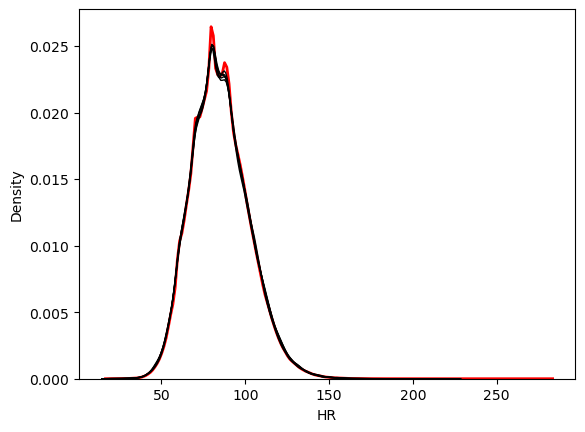

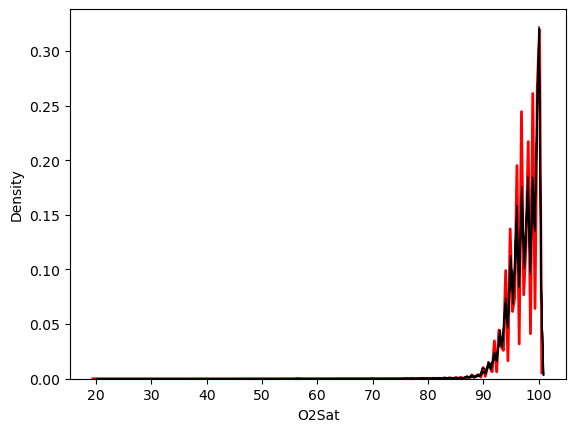

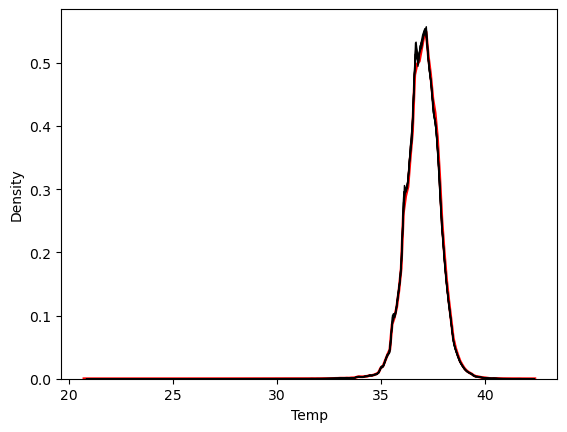

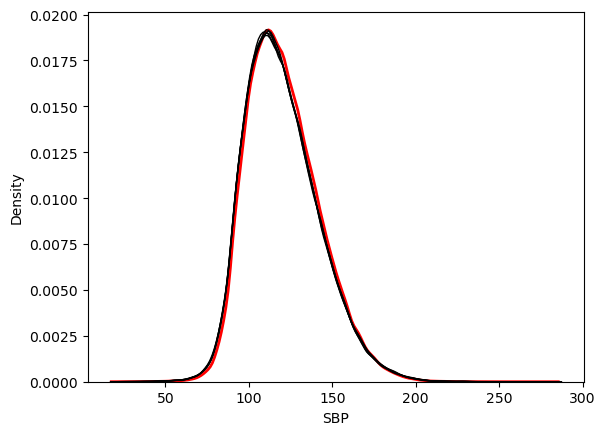

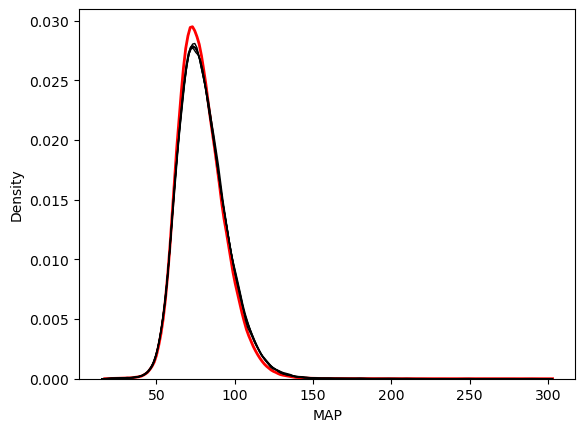

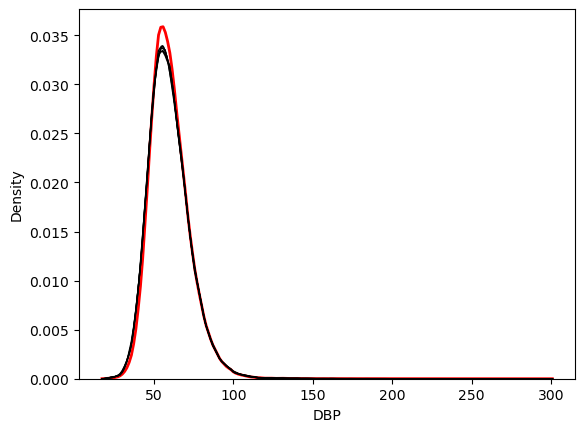

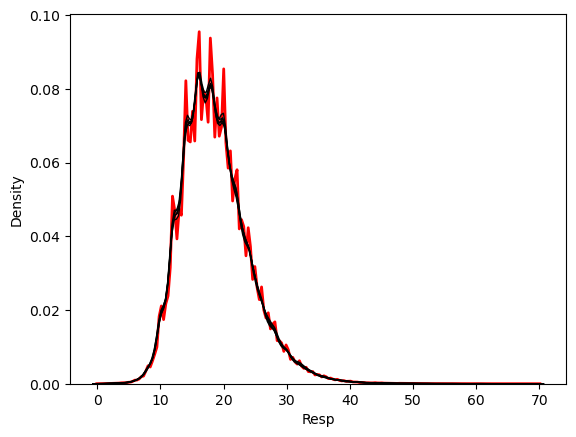

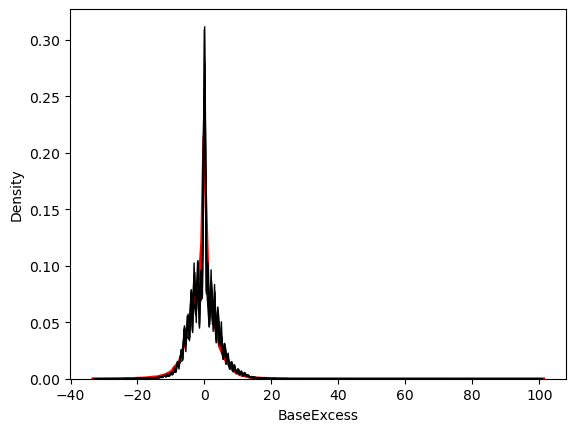

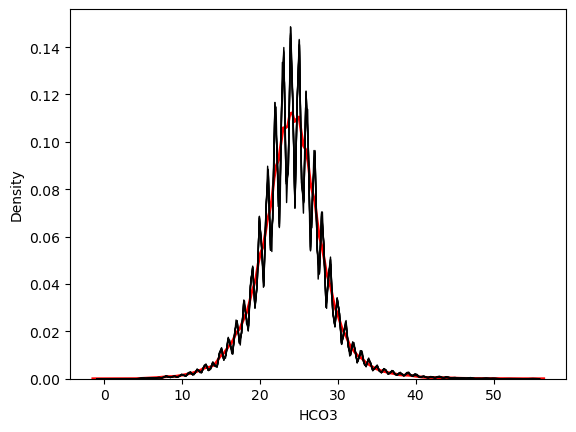

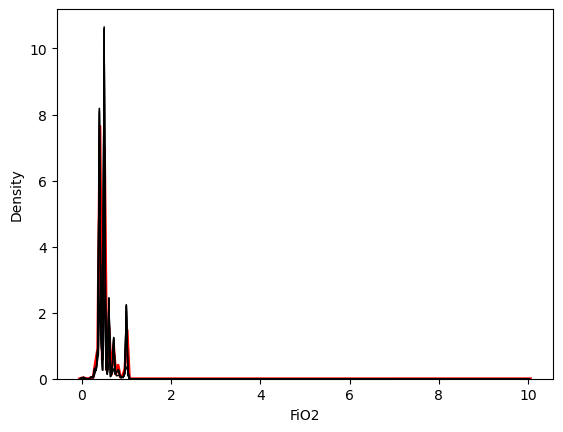

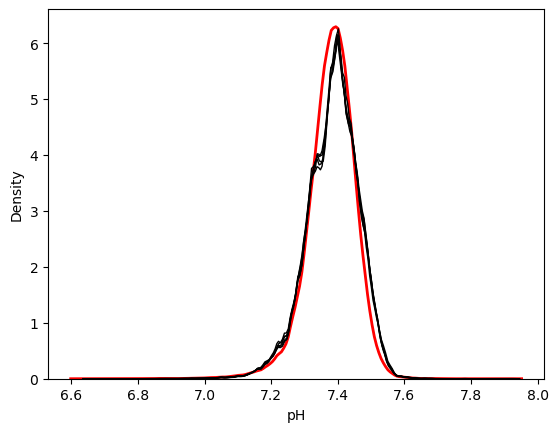

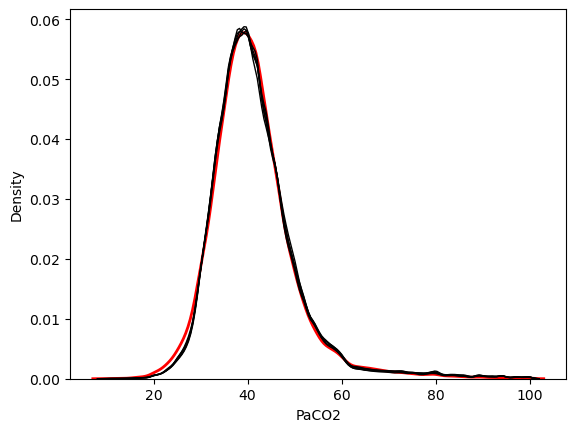

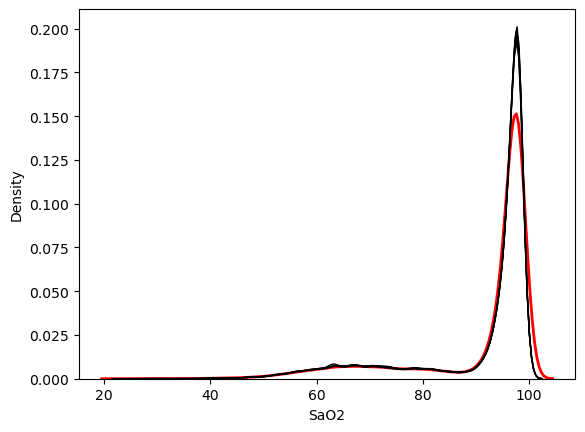

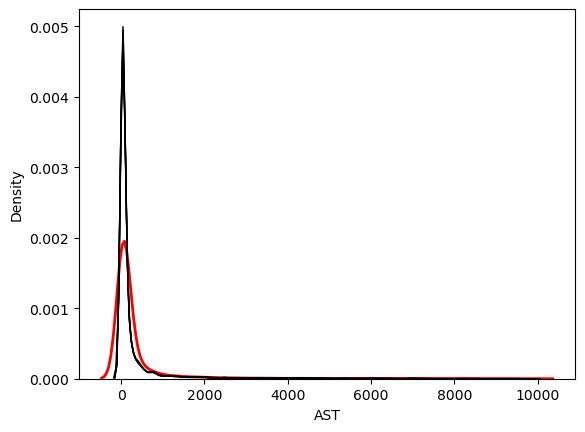

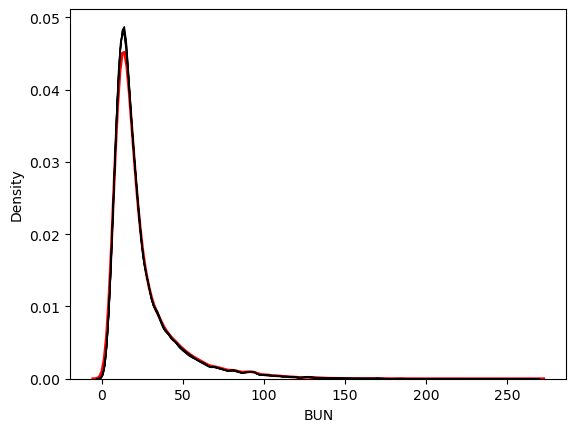

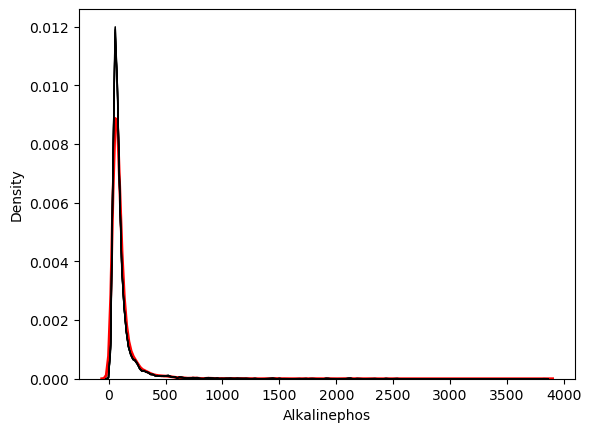

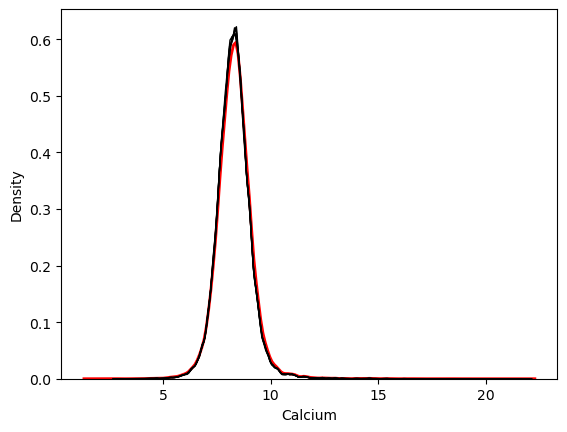

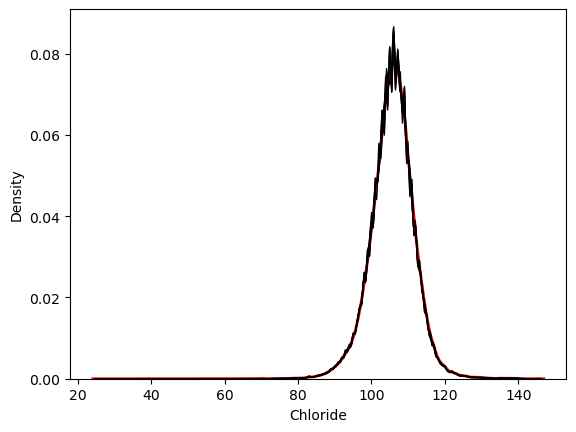

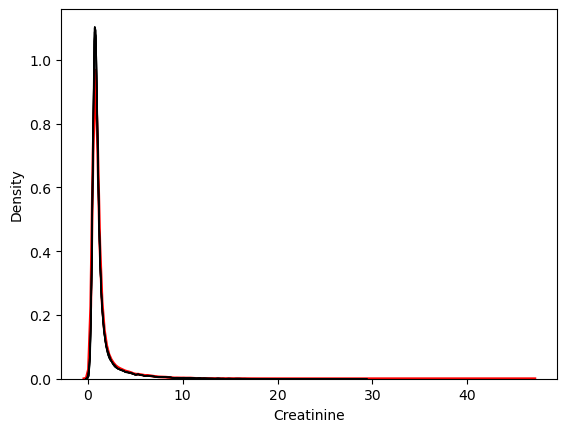

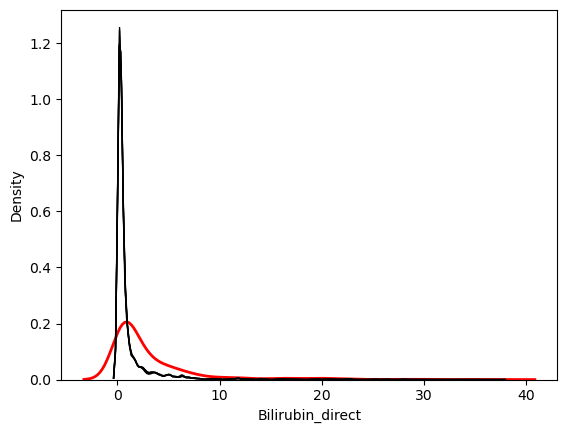

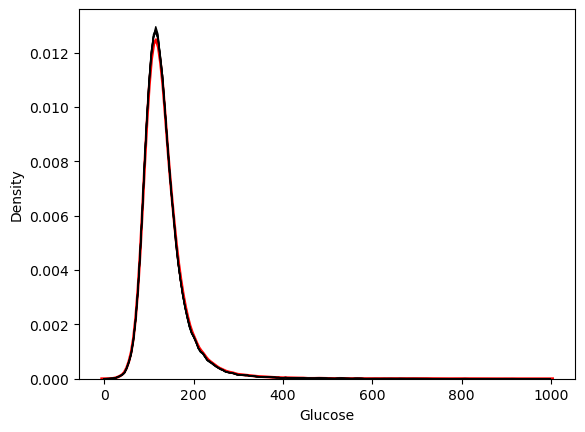

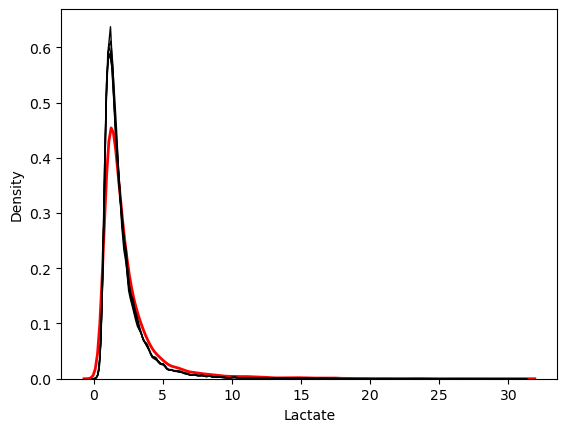

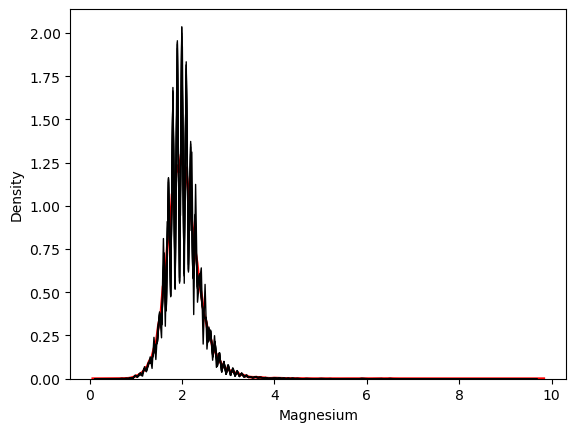

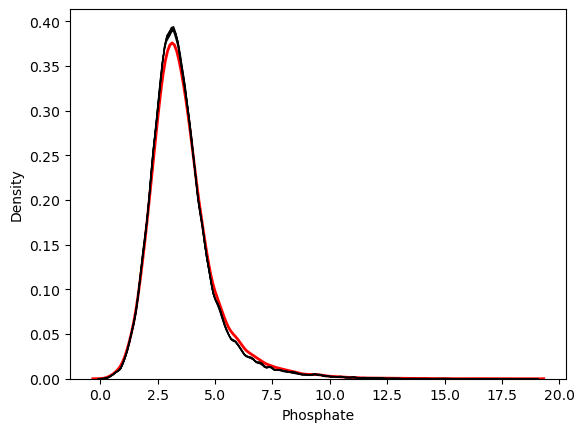

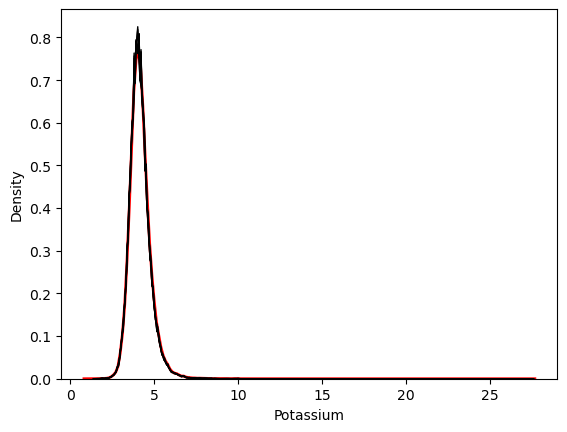

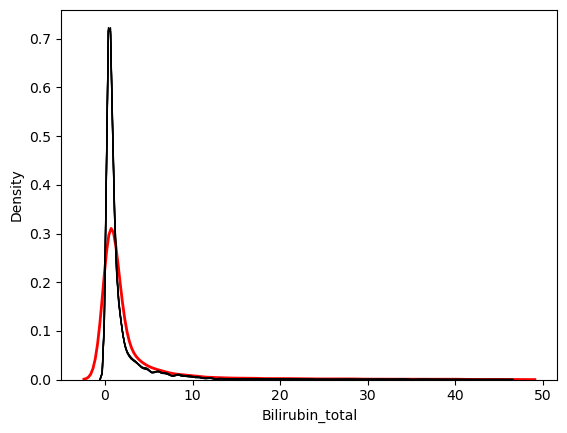

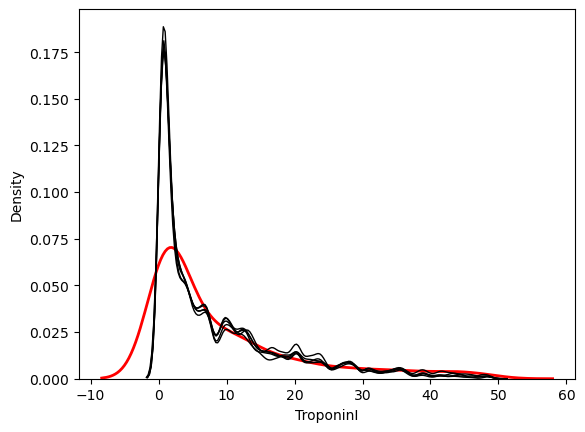

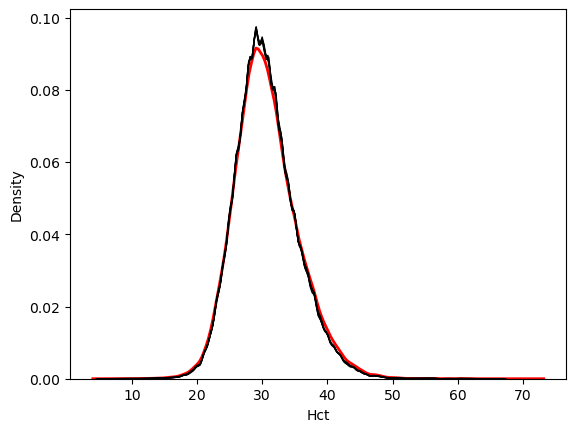

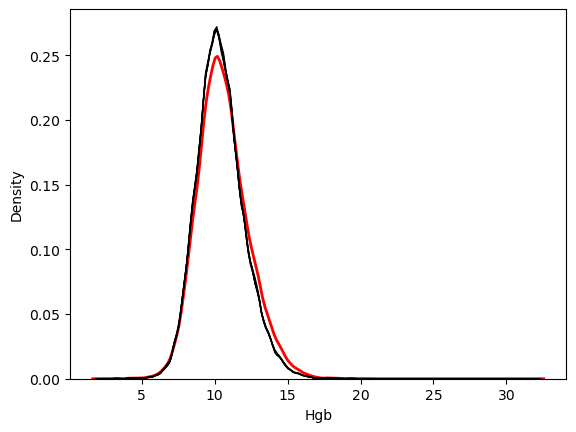

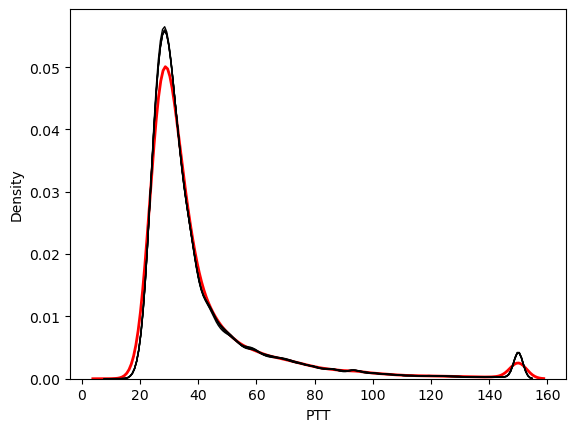

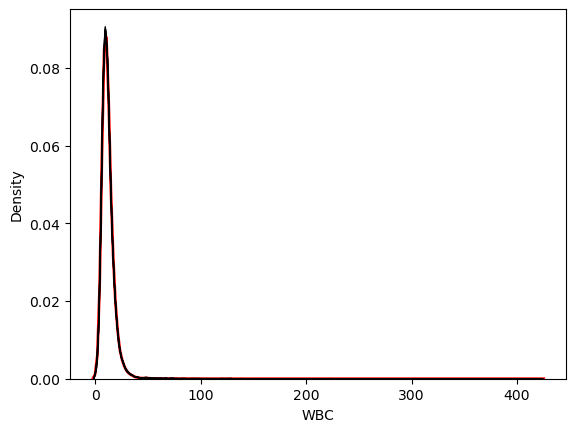

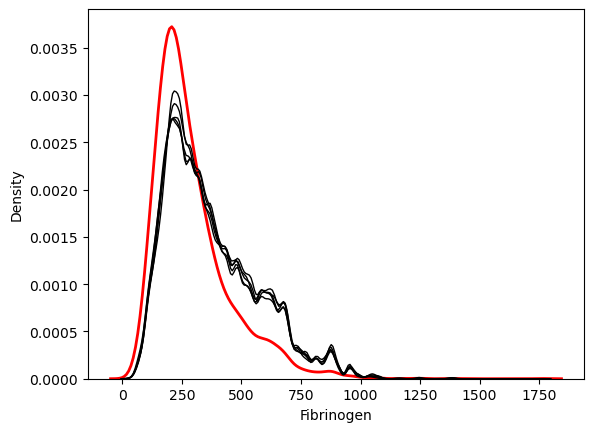

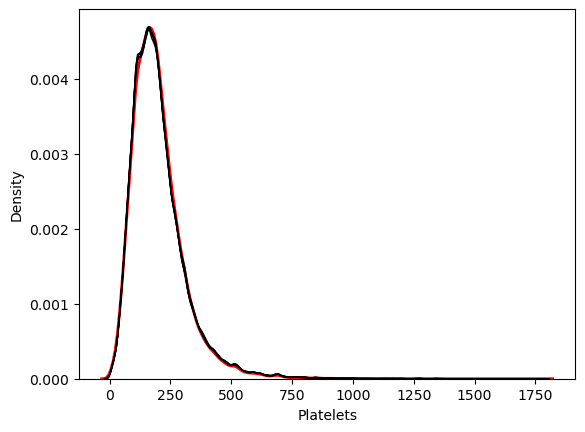

In [658]:
for feature in HospA_df_mice.columns:
    if feature not in ['Age','Gender','SepsisLabel','patient_id','HospAdmTime','Unit1','Unit2','EtCO2']:
        kernel_hosp1.plot_imputed_distributions(wspace=0.3,hspace=0.3,variables=[feature])

In [659]:
X,y=HospA_df_complete.drop("SepsisLabel",axis=1),HospA_df_complete['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:49},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.1s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  10.2s
0.8407905004956446
[[196297  35627]
 [  2116   3025]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91    231924
         1.0       0.08      0.59      0.14      5141

    accuracy                           0.84    237065
   macro avg       0.53      0.72      0.53    237065
weighted avg       0.97      0.84      0.90    237065



In [660]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.839255,0.072203,0.541140,0.127407
O2Sat,0.839938,0.076526,0.576542,0.135117
Temp,0.841115,0.077696,0.581988,0.137090
SBP,0.838209,0.076892,0.587045,0.135974
MAP,0.841284,0.077359,0.578292,0.136464
DBP,0.842440,0.078048,0.579459,0.137566
Resp,0.837956,0.073935,0.561564,0.130666
BaseExcess,0.840381,0.078197,0.589574,0.138080
HCO3,0.841533,0.078905,0.590936,0.139220
FiO2,0.841803,0.078576,0.586851,0.138595


### Concatinating both the MICE imputed data and the Nan encoded data of Hosp 1 

In [666]:
HospA_mice_cat=pd.concat([HospA_df2.drop('SepsisLabel',axis=1),HospA_df_complete],axis=1)
HospA_mice_cat

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,ICULOS,SepsisLabel
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,86.0,99.0,36.56,141.0,85.00,50.0,22.0,-3.0,24.0,0.50,7.26,53.0,95.5,388.0,84.0,143.0,9.3,106.0,6.8,0.7,86.0,3.4,2.8,7.5,6.3,0.6,10.9,36.3,12.3,41.0,25.3,347.0,176.0,83.14,0.0,1.0,0.0
1,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,97.0,95.0,36.67,98.0,75.33,58.0,19.0,0.0,25.0,0.50,7.36,43.0,97.0,22.0,15.0,92.0,8.5,103.0,0.2,0.1,126.0,3.2,1.8,3.0,3.6,0.1,6.7,29.5,10.3,26.5,8.5,252.0,241.0,83.14,0.0,2.0,0.0
2,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,89.0,99.0,36.89,122.0,86.00,60.0,22.0,-3.0,22.0,0.50,7.29,45.0,76.0,89.0,52.0,69.0,8.1,116.0,2.3,4.9,119.0,1.3,2.9,4.8,4.9,6.9,0.8,31.8,11.2,25.9,14.4,422.0,293.0,83.14,0.0,3.0,0.0
3,0,0,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,90.0,95.0,37.11,114.0,72.00,49.0,30.0,24.0,25.0,0.50,7.36,100.0,69.0,318.0,23.0,29.0,7.6,105.0,1.5,0.2,188.0,3.1,2.5,1.7,5.0,0.5,4.0,33.1,10.9,61.6,10.6,266.0,196.0,83.14,0.0,4.0,0.0
4,0,0,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,103.0,88.5,37.33,122.0,91.33,69.0,24.5,-5.0,22.0,0.28,7.25,52.0,97.0,38.0,24.0,83.0,7.3,111.0,0.6,0.4,186.0,3.7,1.8,3.1,3.9,0.8,1.1,24.0,8.0,30.5,5.2,601.0,201.0,83.14,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,0,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,88.0,98.0,37.44,135.0,81.00,64.0,16.0,0.0,26.0,0.50,7.39,41.0,98.0,16.0,41.0,40.0,10.3,97.0,1.6,0.1,115.0,1.1,1.7,3.6,4.1,0.9,7.7,30.0,10.1,150.0,19.1,588.0,291.0,62.29,1.0,31.0,1.0
790211,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,1,0,1,1,1,1,1,96.0,98.0,38.72,174.0,97.00,72.0,16.0,2.0,22.0,0.40,7.48,34.0,97.0,90.0,26.0,107.0,7.4,106.0,2.5,0.4,119.0,0.9,2.2,3.5,3.9,0.9,10.7,27.8,10.0,35.0,15.7,485.0,275.0,62.29,1.0,32.0,1.0
790212,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,140.0,97.0,37.56,133.0,81.50,62.5,16.0,1.0,34.0,0.24,7.39,46.0,94.0,17.0,11.0,191.0,8.8,96.0,0.6,0.4,119.0,1.2,1.9,3.2,4.5,0.9,9.9,28.9,10.1,38.5,18.0,807.0,490.0,62.29,1.0,33.0,1.0
790213,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,120.0,96.0,37.75,154.0,118.00,105.0,16.0,5.0,33.0,0.40,7.49,39.0,97.0,3872.0,10.0,272.0,9.3,99.0,1.0,0.5,290.0,4.6,1.7,3.1,4.2,0.6,26.1,38.0,12.7,56.1,8.0,219.0,167.0,62.29,1.0,34.0,1.0


In [671]:
X,y=HospA_mice_cat.drop("SepsisLabel",axis=1),HospA_mice_cat['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:49},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.4s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  14.8s
0.8463332841203889
[[197443  34481]
 [  1948   3193]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    231924
         1.0       0.08      0.62      0.15      5141

    accuracy                           0.85    237065
   macro avg       0.54      0.74      0.53    237065
weighted avg       0.97      0.85      0.90    237065



### Imputing the NaN by MICE algo on Hospital 2

In [674]:
HospB_df_mice=HospB_df.drop(['patient_id','HospAdmTime','Unit1','Unit2'],axis=1)
HospB_df_complete,kernel_hosp2 = MICE_Imputer(HospB_df_mice)
HospB_df_complete


              Class: ImputationKernel
           Datasets: 5
         Iterations: 8
       Data Samples: 761995
       Data Columns: 38
  Imputed Variables: 34
save_all_iterations: True


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,ICULOS,SepsisLabel
0,67.0,98.0,36.05,160.0,80.5,49.0,16.0,32.0,-0.55,24.50,0.21,7.40,36.0,94.8,27.0,15.0,74.0,7.38,104.0,0.77,0.43,109.0,0.50,1.2,3.2,3.70,1.1,0.86,25.3,8.1,33.2,7.8,295.0,264.0,73.0,1.0,1.0,0.0
1,93.0,92.5,35.80,110.0,76.0,56.0,22.0,31.0,3.30,27.50,0.21,7.46,26.0,98.1,18.0,40.0,109.0,9.10,106.0,7.80,0.10,86.0,2.20,1.9,3.6,4.10,0.5,0.14,23.5,7.5,39.0,6.3,343.0,144.0,73.0,1.0,2.0,0.0
2,91.0,96.0,36.40,108.0,84.5,72.0,23.5,18.5,-2.70,21.30,0.70,7.51,25.0,95.7,104.0,10.0,118.0,8.70,106.0,0.51,0.10,233.0,1.32,1.7,2.2,4.10,0.6,1.49,41.0,14.0,31.9,9.2,202.0,150.0,73.0,1.0,3.0,0.0
3,93.0,98.0,36.40,123.0,87.0,61.0,21.0,36.5,0.50,25.10,0.40,7.45,39.0,98.1,28.0,34.0,63.0,7.40,110.0,2.03,0.70,112.0,0.70,1.5,2.8,4.10,1.7,5.84,32.6,10.5,38.4,25.3,454.0,160.0,73.0,1.0,4.0,0.0
4,93.0,95.0,36.30,110.0,81.0,70.0,20.0,21.0,-7.00,19.50,0.30,7.34,29.0,95.9,14.0,12.0,60.0,7.90,118.0,0.87,0.10,236.0,5.10,2.0,8.4,3.90,0.9,0.03,26.0,8.4,65.5,7.4,254.0,179.0,73.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761990,80.0,96.0,36.40,115.0,87.0,65.0,15.0,27.0,-1.10,23.20,0.50,7.50,27.0,98.8,13.0,12.0,83.0,9.20,114.0,0.60,0.10,136.0,3.24,1.9,1.9,3.60,1.4,0.20,18.1,5.7,61.5,10.4,258.0,136.0,62.0,0.0,31.0,0.0
761991,74.0,97.0,36.50,114.0,83.0,67.0,15.0,94.0,-0.20,24.30,1.00,7.39,36.4,96.5,27.0,12.0,129.0,7.80,106.5,0.62,0.50,102.0,2.50,1.8,4.2,4.21,1.6,186.88,27.1,9.0,108.2,149.0,194.0,162.0,62.0,0.0,32.0,0.0
761992,78.0,98.0,35.80,110.0,83.0,69.0,15.0,30.0,-1.80,23.45,0.40,7.36,43.0,99.7,25.0,13.0,47.0,1.15,108.0,0.72,0.40,155.0,1.72,3.4,2.1,3.80,1.2,1.07,26.0,8.8,23.8,8.1,215.0,73.0,62.0,0.0,33.0,0.0
761993,82.0,99.0,36.60,124.0,91.0,71.0,16.0,31.5,-4.10,21.55,0.30,7.37,35.0,98.3,64.0,50.0,68.0,8.10,109.0,4.67,0.70,242.0,6.95,2.2,3.9,4.10,1.3,135.50,21.5,7.1,164.4,10.7,180.0,110.0,62.0,0.0,34.0,0.0


C:\Users\Admin\anaconda3\envs\env2\lib\site-packages\miceforest\ImputedData.py:623: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(plotrows, plotcols, squeeze=False)


AssertionError: 

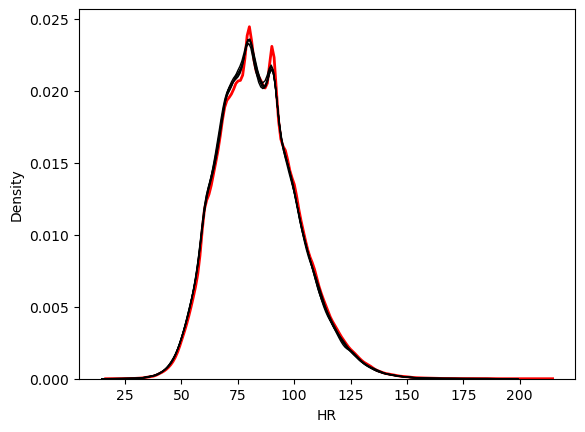

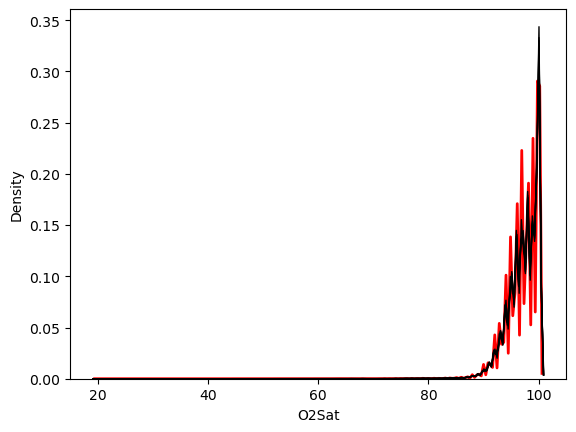

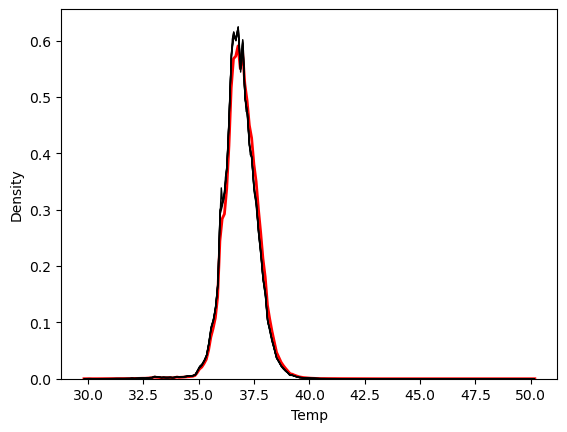

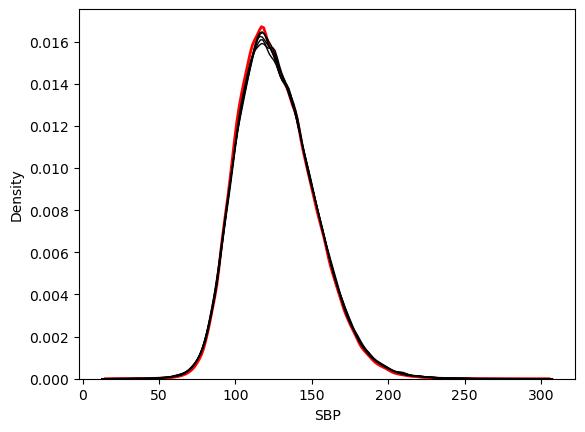

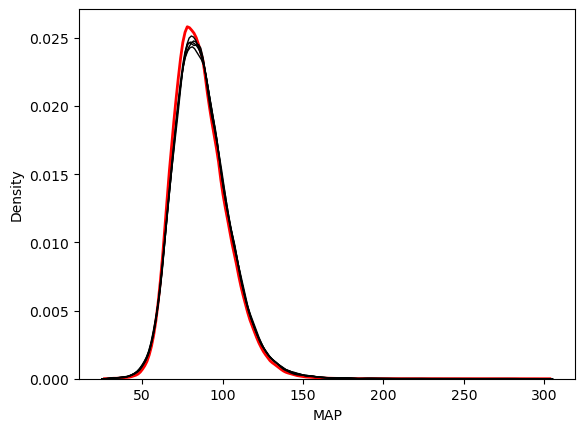

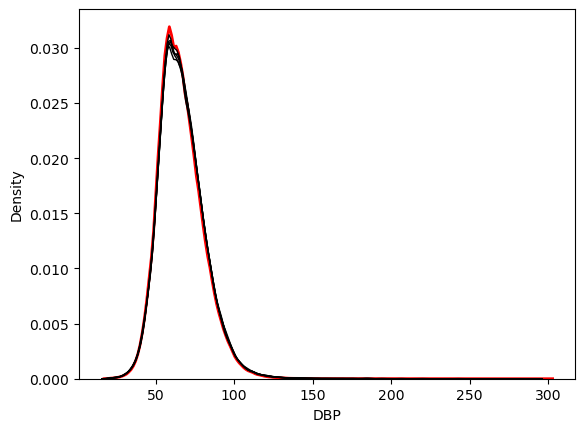

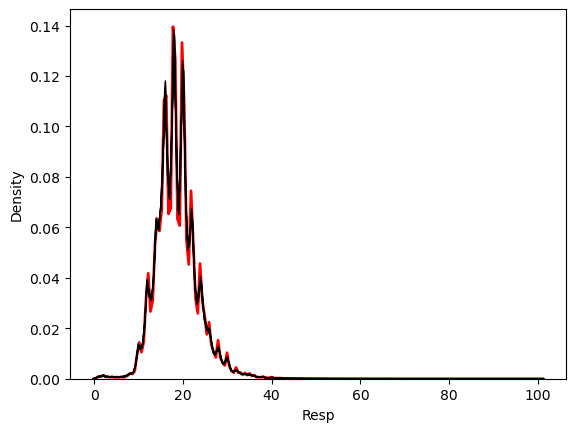

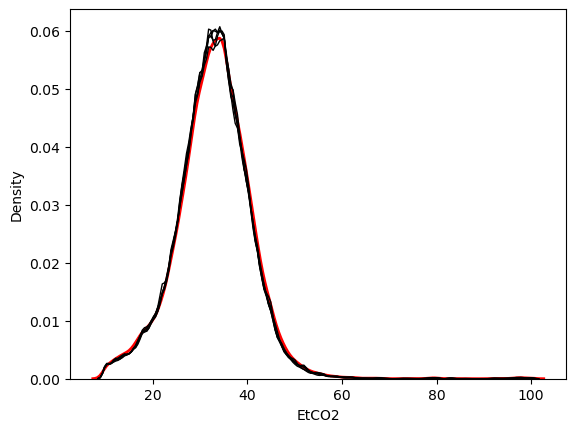

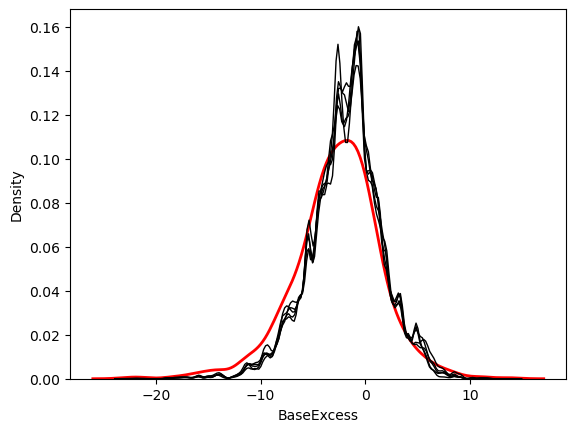

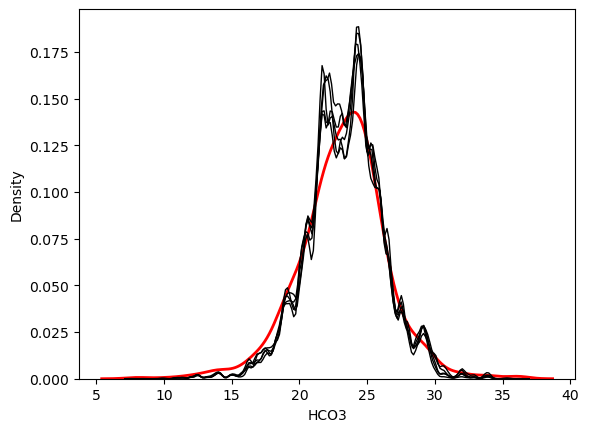

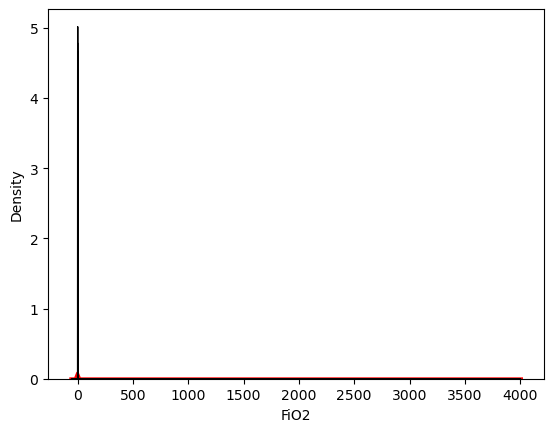

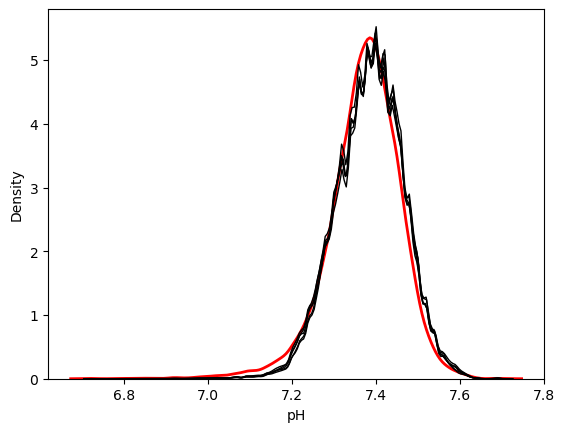

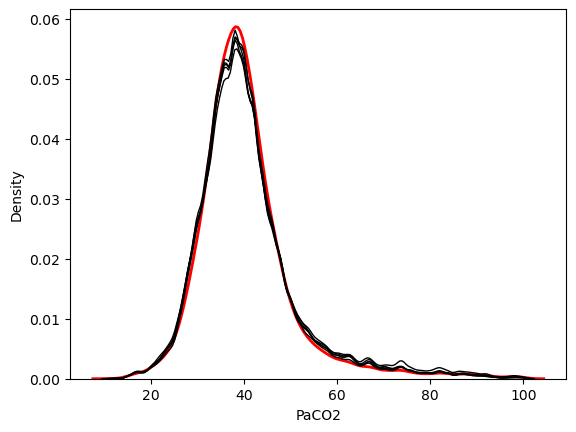

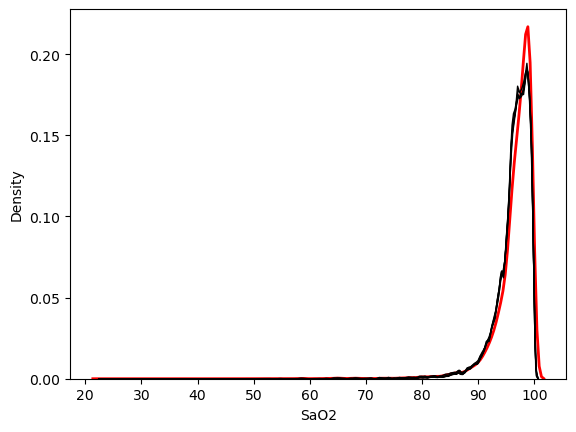

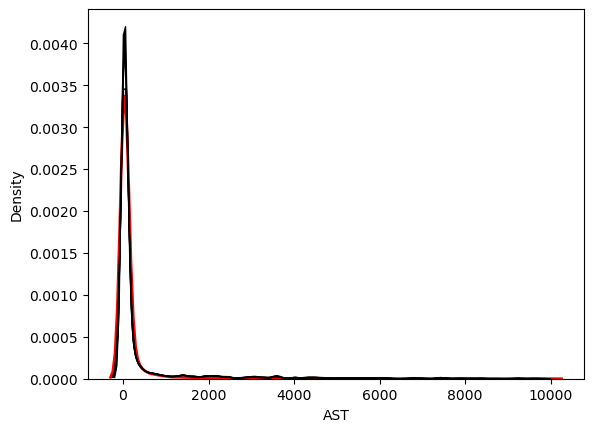

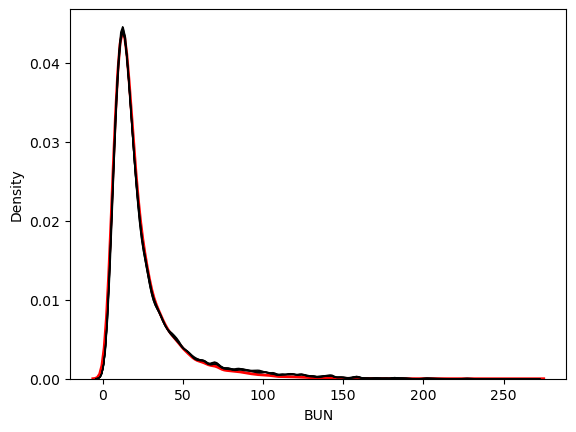

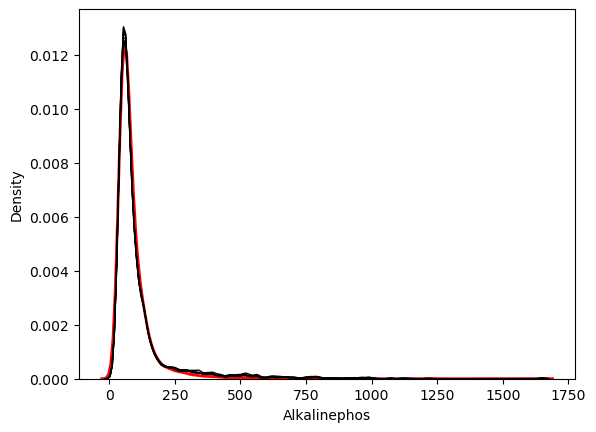

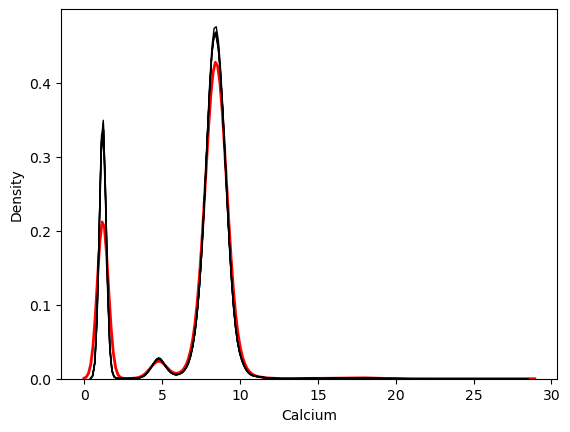

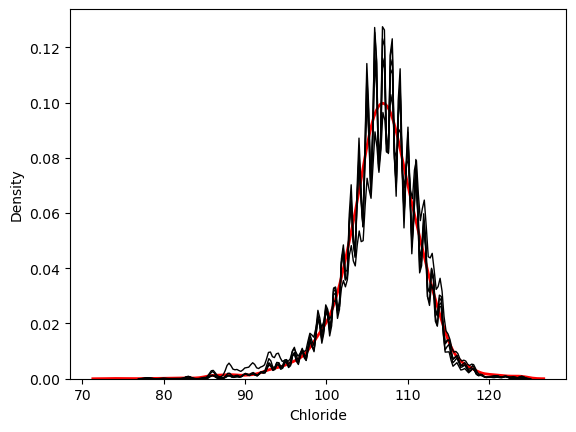

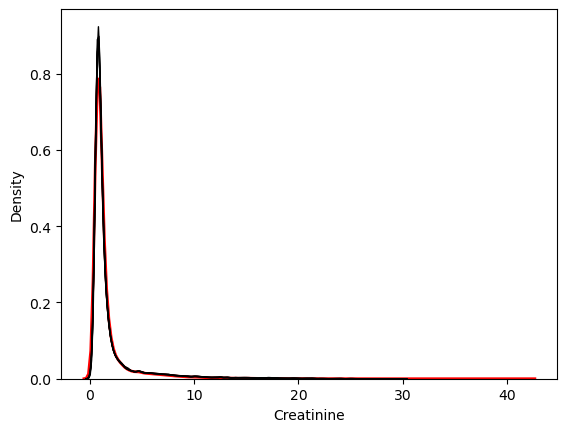

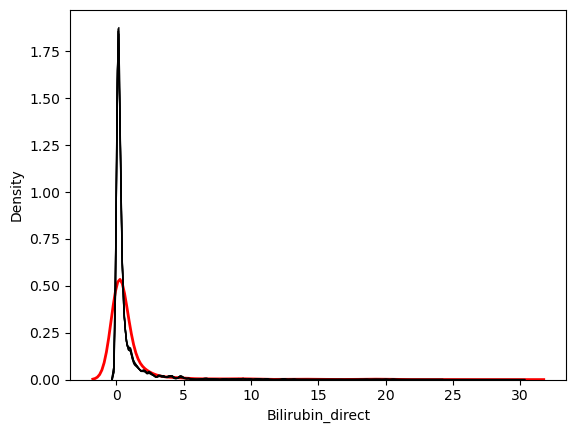

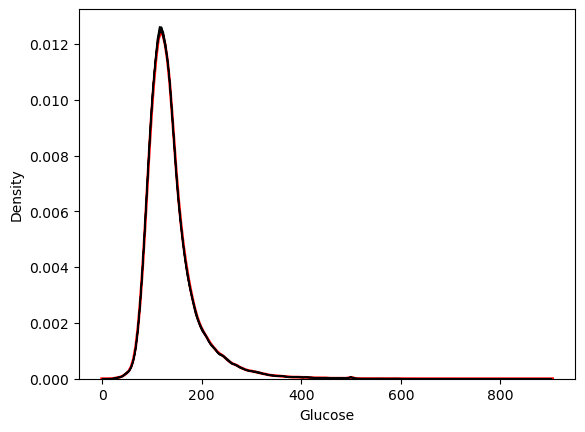

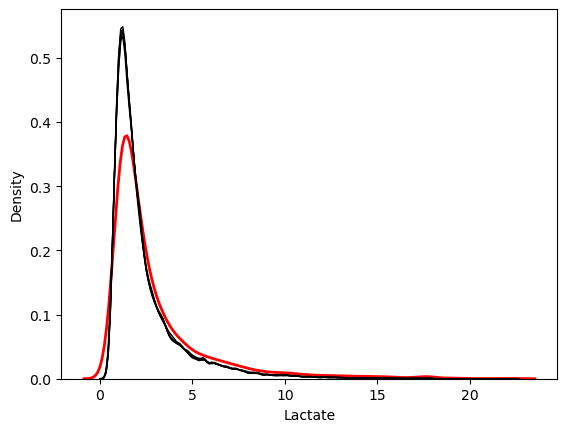

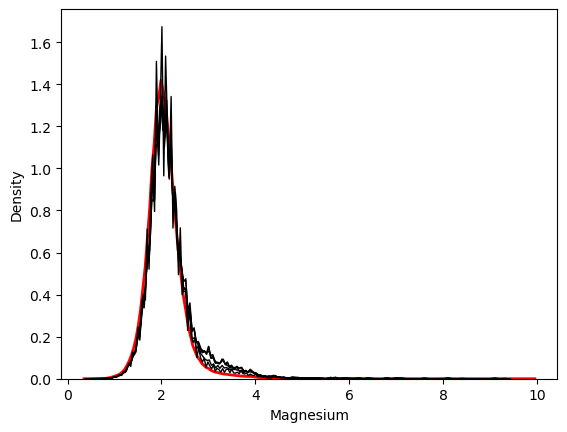

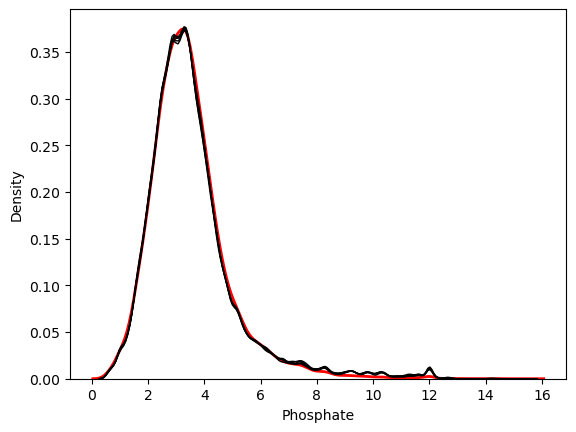

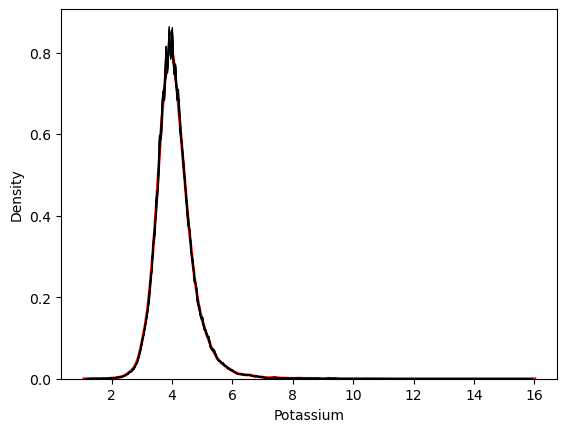

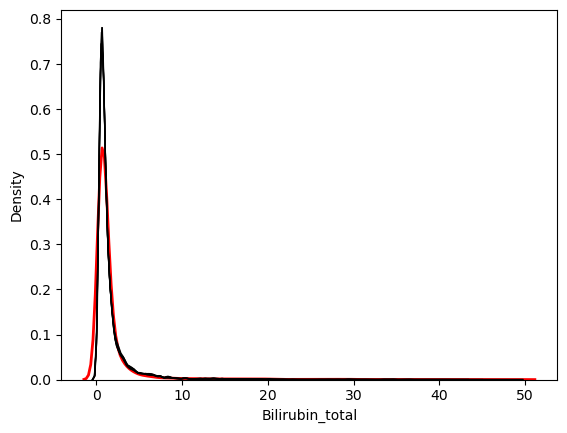

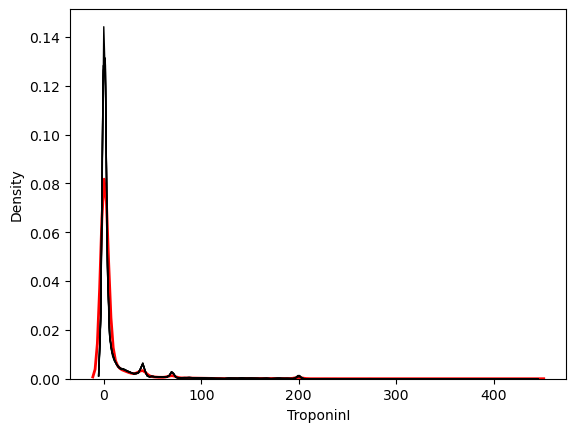

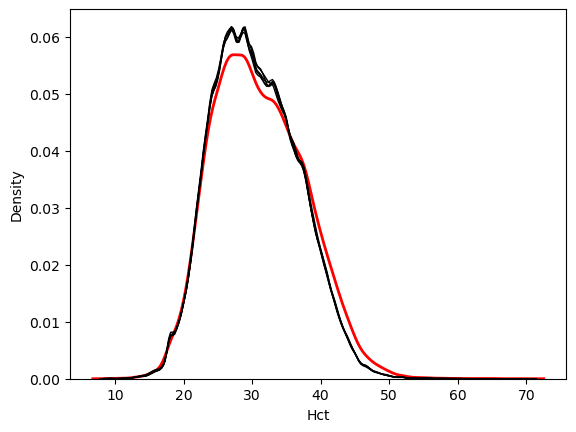

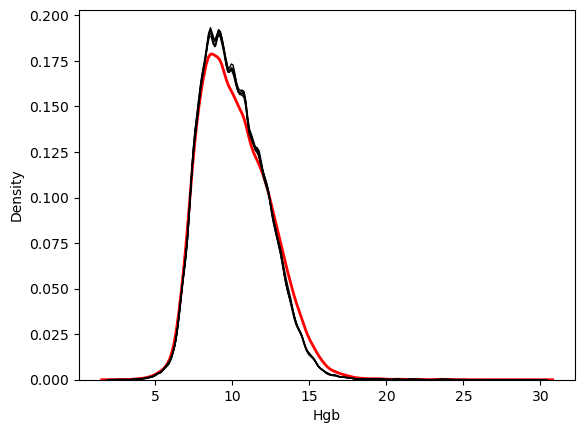

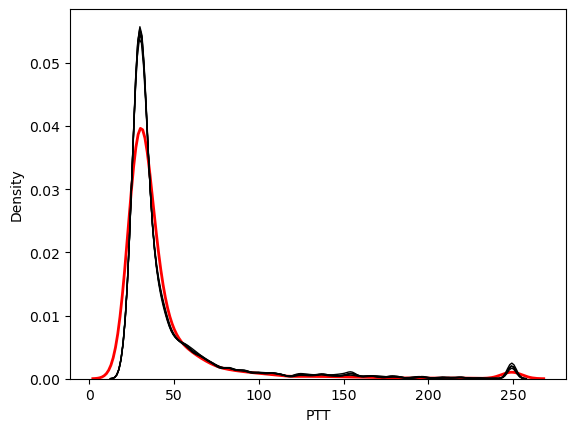

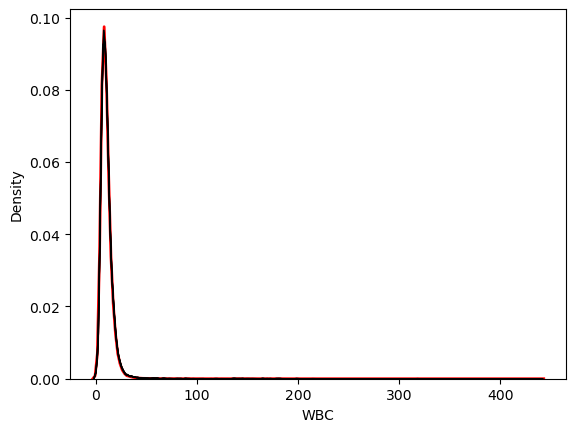

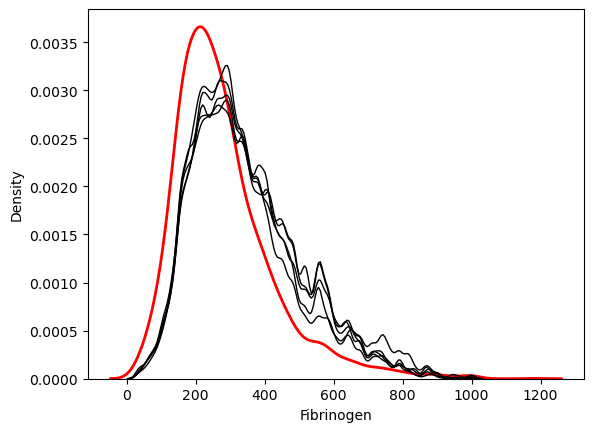

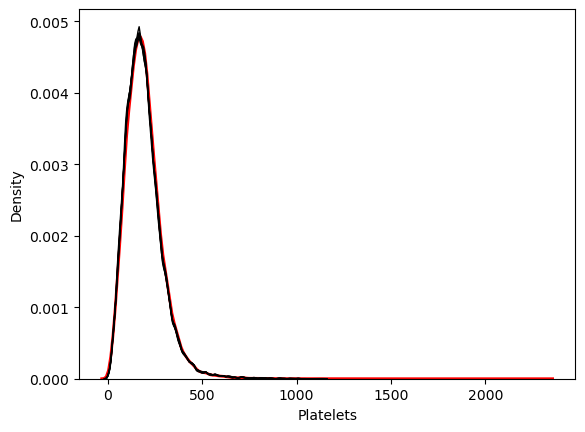

In [676]:
for feature in HospB_df_mice.columns:
    if feature not in ['Age','Gender','SepsisLabel','patient_id','HospAdmTime','Unit1','Unit2']:
        kernel_hosp2.plot_imputed_distributions(wspace=0.3,hspace=0.3,variables=[feature])

In [677]:
X,y=HospB_df_complete.drop("SepsisLabel",axis=1),HospB_df_complete['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.1s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  10.5s
0.8097585728721473
[[183285  42080]
 [  1409   1825]]
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    225365
         1.0       0.04      0.56      0.08      3234

    accuracy                           0.81    228599
   macro avg       0.52      0.69      0.49    228599
weighted avg       0.98      0.81      0.88    228599



In [678]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.811329,0.038945,0.521027,0.072473
O2Sat,0.809920,0.040534,0.548547,0.075489
Temp,0.810301,0.040151,0.541744,0.074762
SBP,0.813525,0.041076,0.545145,0.076396
MAP,0.813057,0.040889,0.543908,0.076060
DBP,0.815327,0.040458,0.530612,0.075184
Resp,0.808621,0.040761,0.555968,0.075953
EtCO2,0.809899,0.041681,0.565553,0.077640
BaseExcess,0.826150,0.043467,0.537415,0.080429
HCO3,0.823687,0.042931,0.538343,0.079521


### Concatinating both the MICE imputed data and the Nan encoded data of Hosp 2

In [687]:
HospB_mice_cat=pd.concat([HospB_df2.drop('SepsisLabel',axis=1),HospB_df_complete],axis=1)
HospB_mice_cat.shape

(761995, 72)

In [688]:
X,y=HospB_mice_cat.drop("SepsisLabel",axis=1),HospB_mice_cat['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.4s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  15.7s
0.8262372101365273
[[186957  38408]
 [  1314   1920]]
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90    225365
         1.0       0.05      0.59      0.09      3234

    accuracy                           0.83    228599
   macro avg       0.52      0.71      0.50    228599
weighted avg       0.98      0.83      0.89    228599



### Imputing the NaN by MICE algo on both Hospitals

In [691]:
dataset_AB = dataset_AB.sample(frac = 1,ignore_index=True)
dataset_AB.shape

(1552210, 42)

In [693]:
HospAB_df_mice=dataset_AB.drop(['patient_id','HospAdmTime','Unit1','Unit2'],axis=1)
HospAB_df_complete,kernel_hosp12 = MICE_Imputer(HospAB_df_mice)
HospAB_df_complete


              Class: ImputationKernel
           Datasets: 5
         Iterations: 8
       Data Samples: 1552210
       Data Columns: 38
  Imputed Variables: 34
save_all_iterations: True


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,ICULOS,SepsisLabel
0,82.0,100.0,37.44,165.00,112.00,77.0,11.0,34.0,-7.0,20.0,0.4,7.22,55.0,99.1,18.0,13.0,77.0,1.11,111.0,0.70,0.09,101.0,1.00,2.0,2.8,4.2,0.5,0.03,33.2,10.0,23.3,8.9,407.0,241.0,61.68,0.0,70.0,0.0
1,80.0,99.0,36.44,132.00,78.00,54.0,15.0,27.0,1.0,24.0,0.4,7.39,46.0,96.0,22.0,15.0,49.0,7.90,108.0,0.50,0.10,154.0,1.20,1.8,3.0,4.5,0.4,2.39,27.4,9.2,32.7,15.3,286.0,153.0,81.60,1.0,25.0,0.0
2,81.0,96.0,36.90,78.25,67.83,30.5,30.0,25.0,-1.0,31.0,0.4,7.39,39.2,56.0,78.0,19.0,60.0,8.40,105.0,1.00,0.10,122.0,1.72,2.1,2.2,4.3,1.0,36.92,29.0,10.5,28.4,16.2,581.0,198.0,68.37,0.0,31.0,0.0
3,86.0,97.0,36.83,145.00,101.00,74.0,15.0,26.0,3.0,21.0,0.4,7.44,40.0,99.0,16.0,37.0,28.0,8.50,108.0,1.23,0.23,119.0,1.50,2.1,4.3,4.0,0.8,0.03,30.5,10.4,34.5,10.3,300.0,411.0,69.68,1.0,13.0,0.0
4,70.0,100.0,37.22,152.00,93.00,68.0,21.0,73.0,3.0,29.0,0.4,7.50,31.0,41.0,23.0,20.0,66.0,8.40,106.0,4.52,0.07,144.0,1.10,1.8,3.6,3.8,0.5,0.07,22.4,7.6,26.8,14.3,684.0,321.0,20.96,1.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,95.0,100.0,37.50,120.00,90.00,73.0,15.5,33.0,4.0,31.0,0.4,7.45,40.0,99.0,49.0,14.0,72.0,8.90,97.0,0.50,0.10,104.0,0.70,2.1,4.0,4.1,0.7,0.03,35.4,11.4,35.7,8.2,622.0,436.0,42.74,1.0,173.0,0.0
1552206,130.0,96.0,37.50,144.00,97.33,72.0,20.0,34.0,-3.0,25.0,0.5,7.19,62.0,97.0,598.0,12.0,98.0,8.30,104.0,0.68,1.30,178.0,6.20,1.5,3.7,3.7,2.9,2.17,33.8,10.8,41.6,20.0,138.0,156.0,36.61,0.0,3.0,0.0
1552207,90.0,96.0,37.70,174.00,114.00,78.0,23.0,38.0,0.0,21.0,0.5,7.39,42.5,97.2,13.0,13.0,65.0,8.10,98.0,0.80,0.27,129.0,1.90,1.8,2.4,3.9,1.8,0.04,32.3,11.1,42.3,7.4,255.0,145.0,79.00,0.0,31.0,0.0
1552208,50.0,100.0,32.35,123.00,68.00,53.0,13.0,28.0,0.0,25.0,1.0,7.44,33.3,93.0,24.0,4.0,53.0,8.20,107.0,0.67,0.30,178.0,1.30,1.7,3.8,4.1,0.3,0.03,21.8,6.8,28.3,15.4,192.0,308.0,57.00,0.0,1.0,0.0


C:\Users\Admin\anaconda3\envs\env2\lib\site-packages\miceforest\ImputedData.py:623: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(plotrows, plotcols, squeeze=False)


AssertionError: 

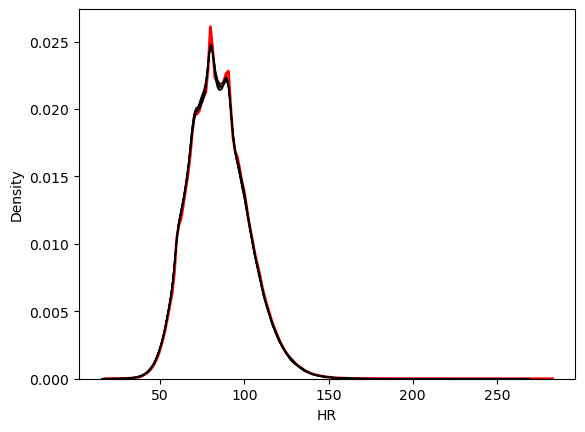

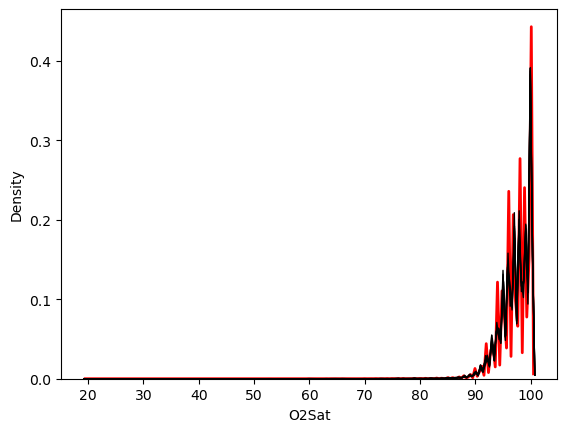

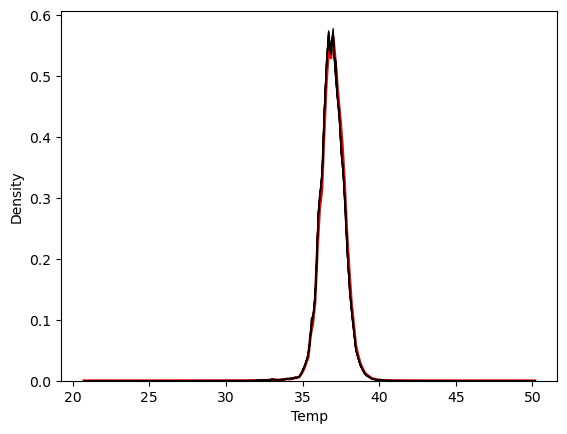

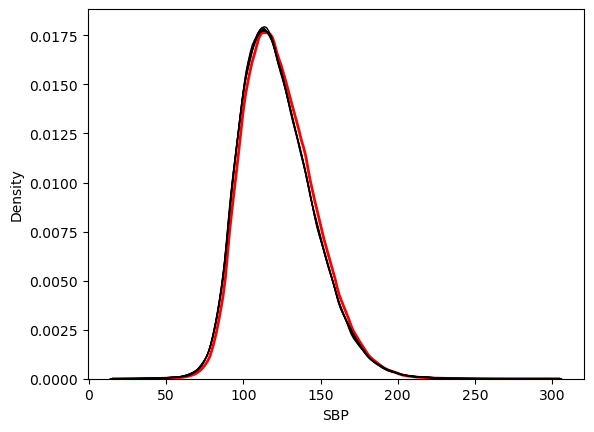

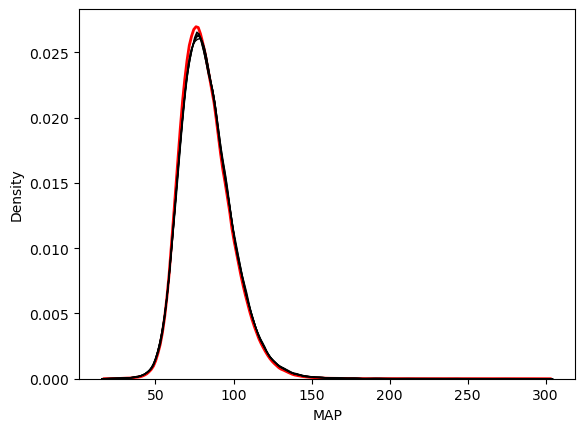

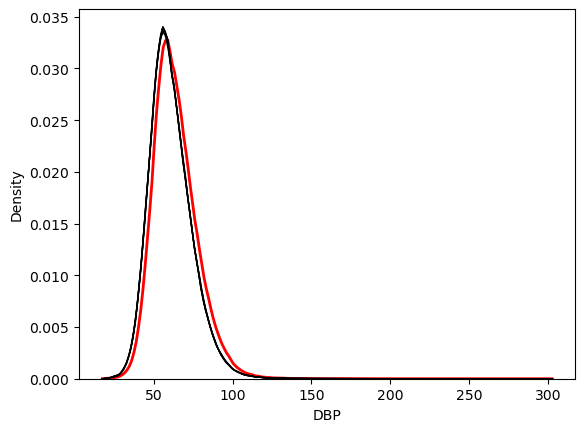

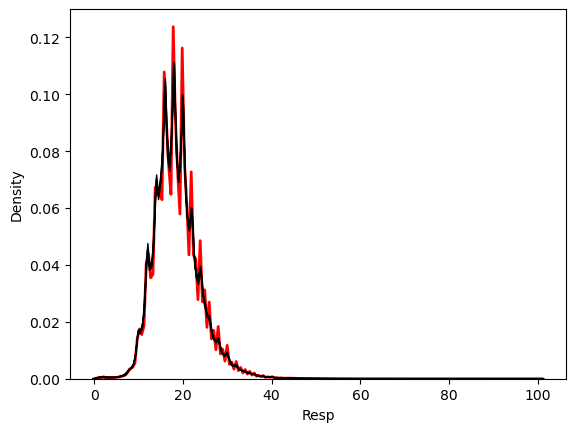

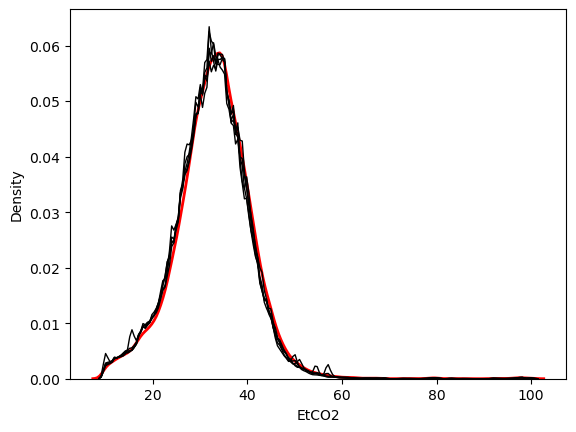

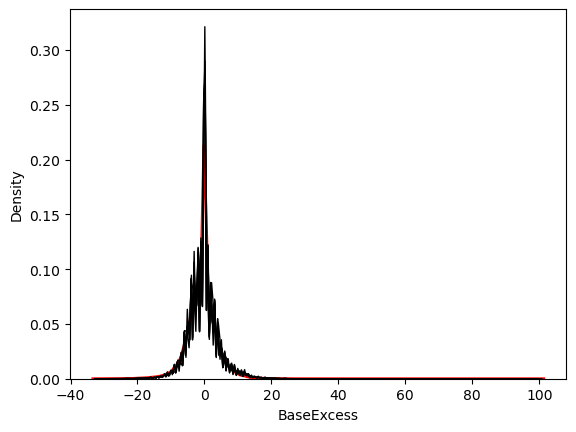

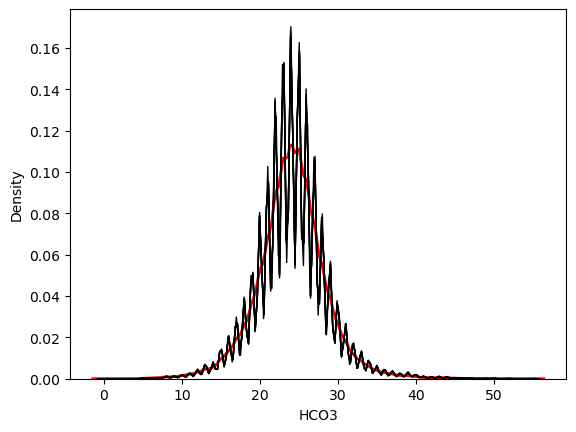

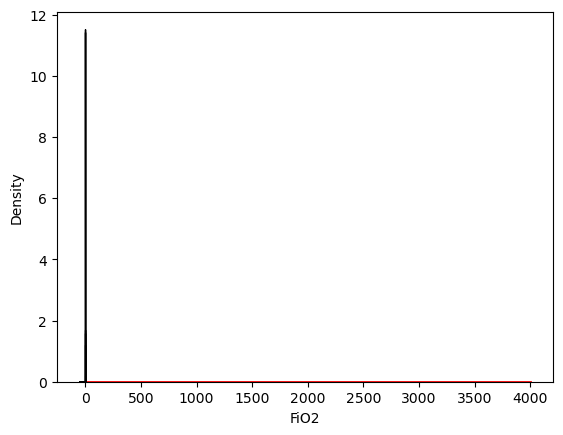

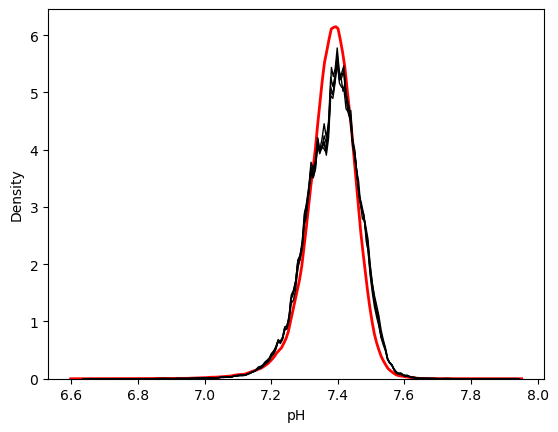

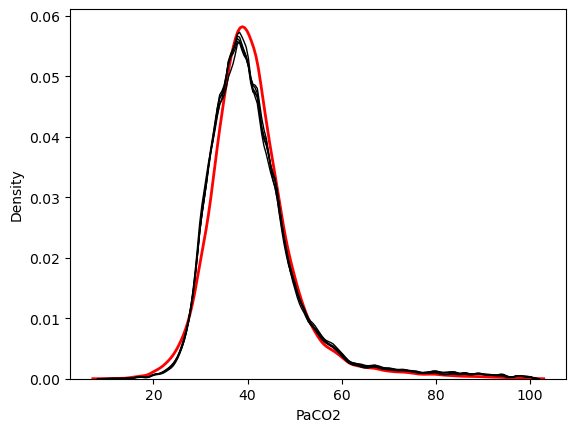

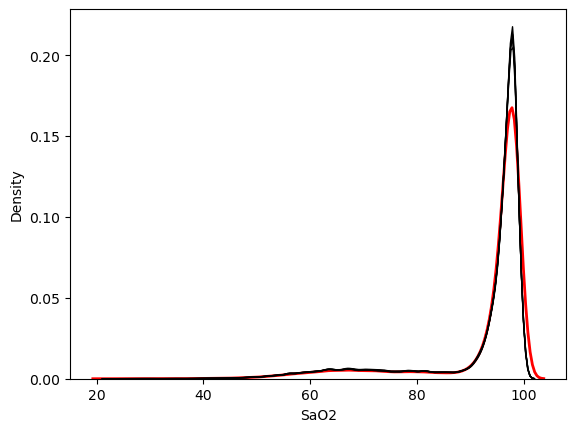

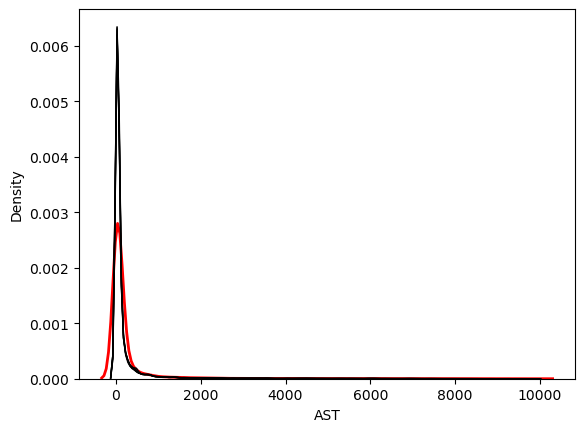

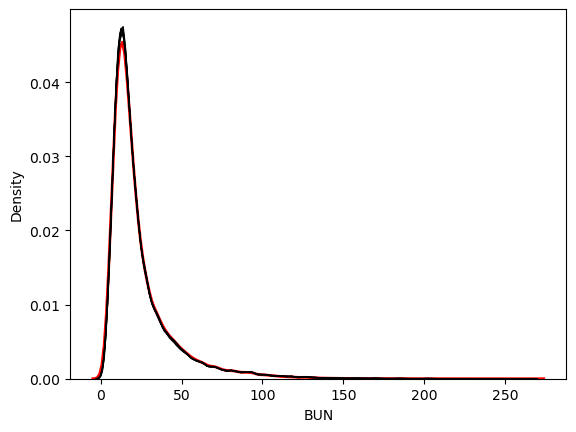

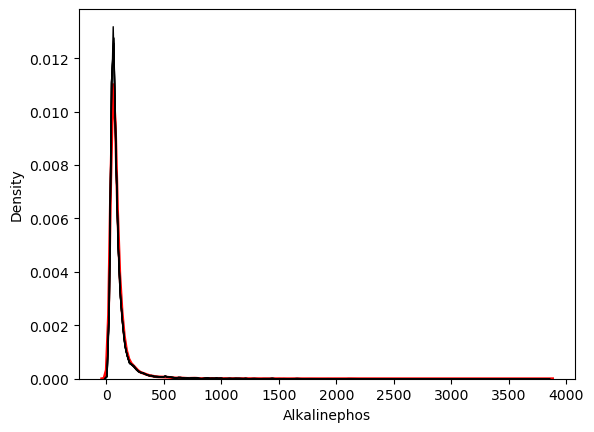

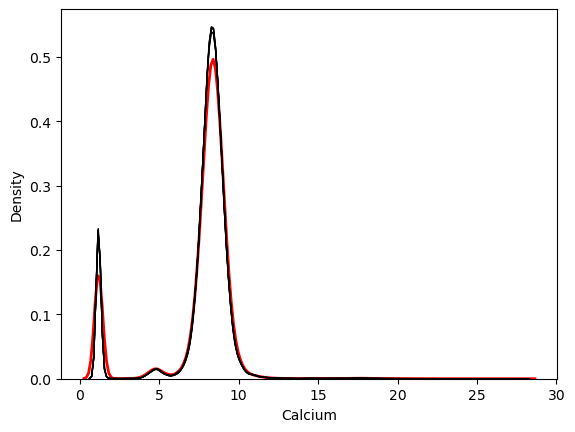

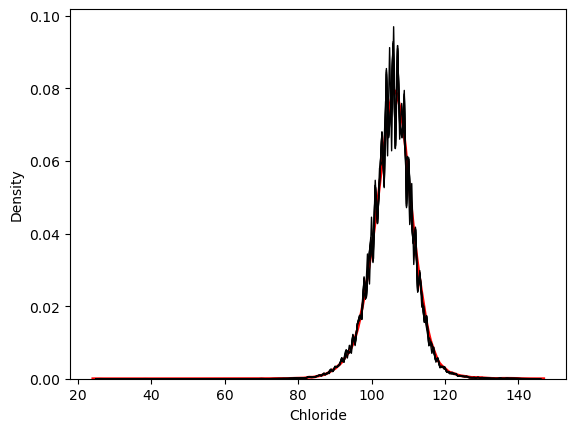

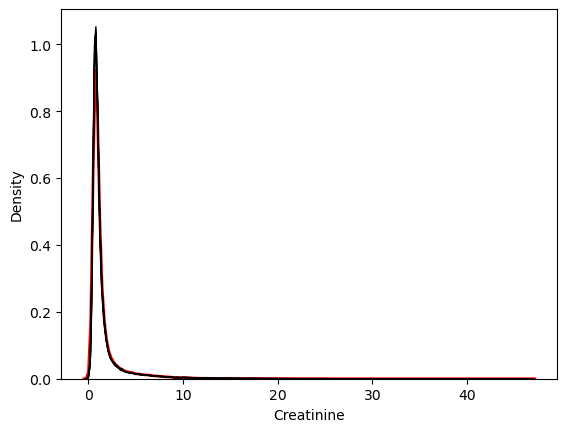

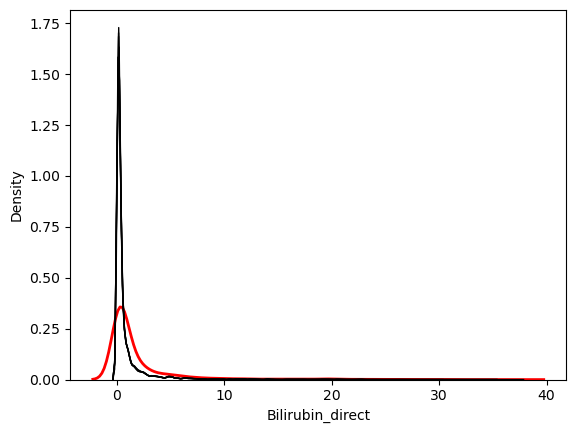

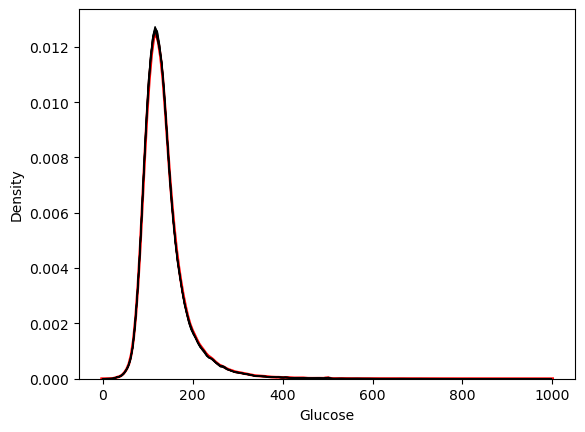

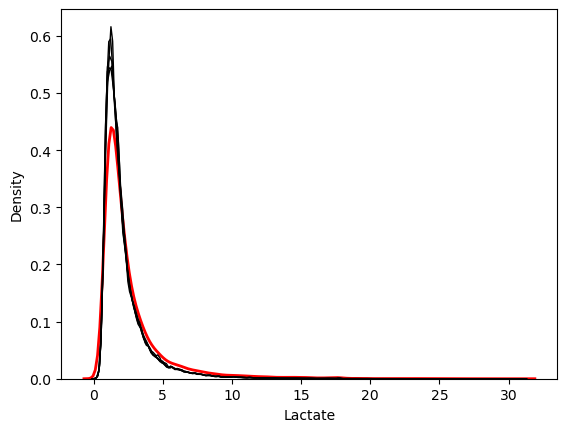

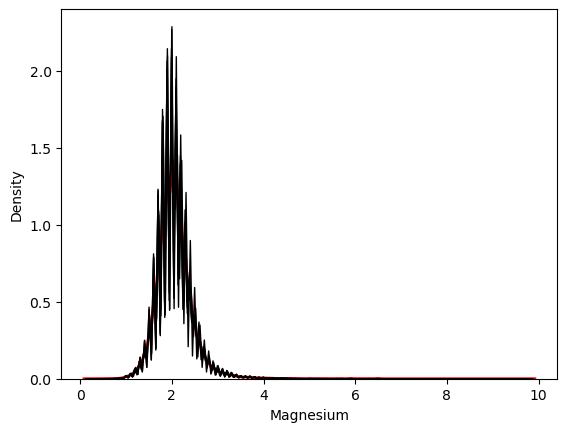

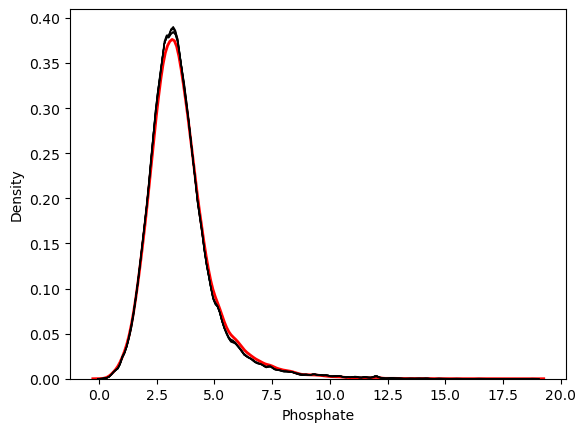

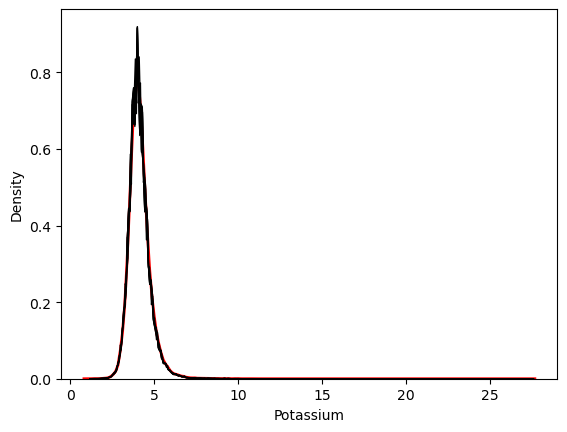

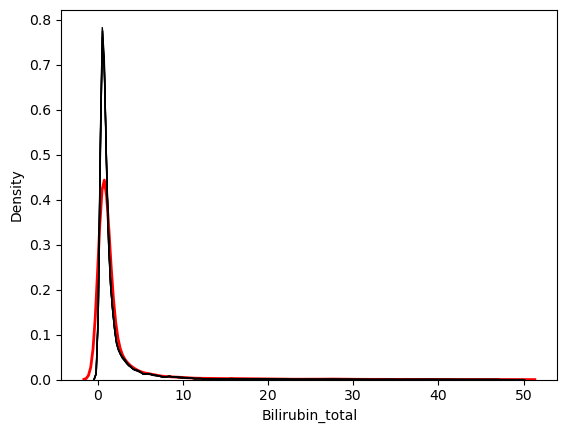

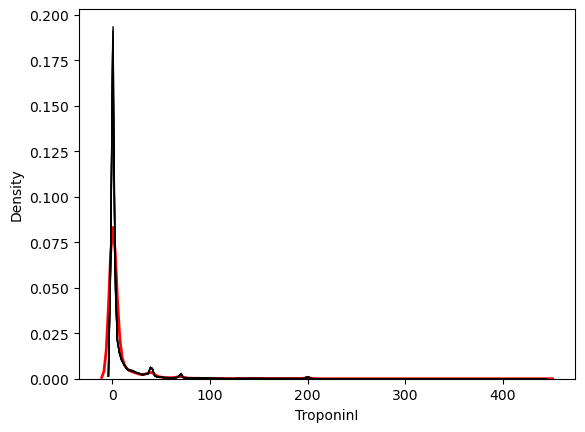

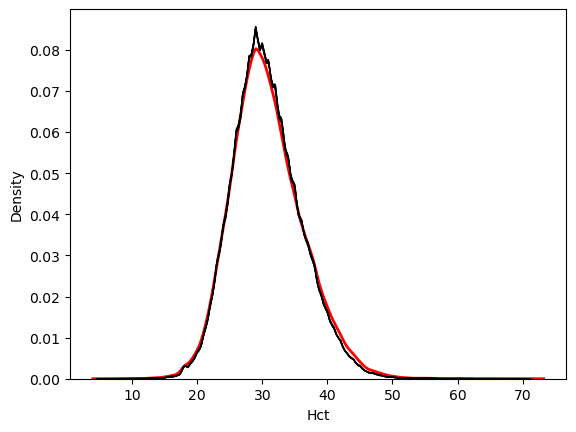

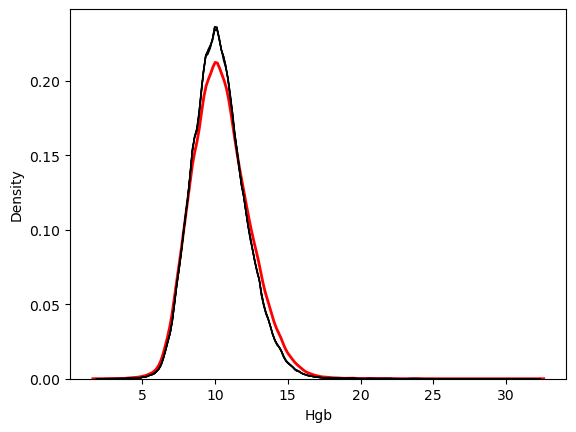

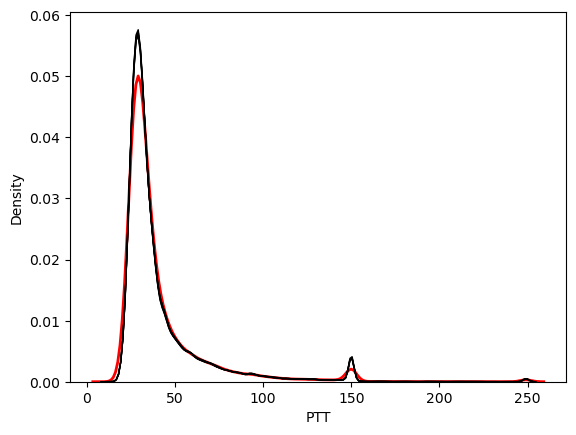

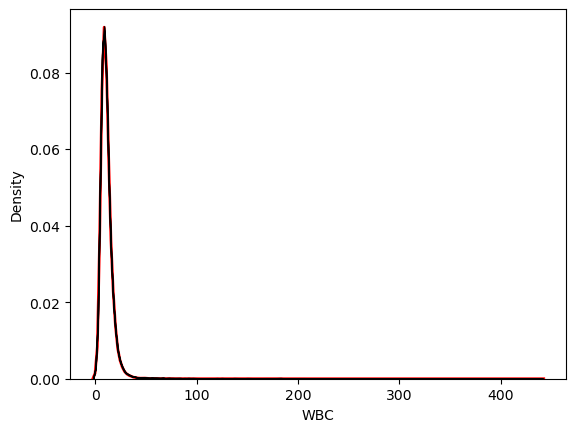

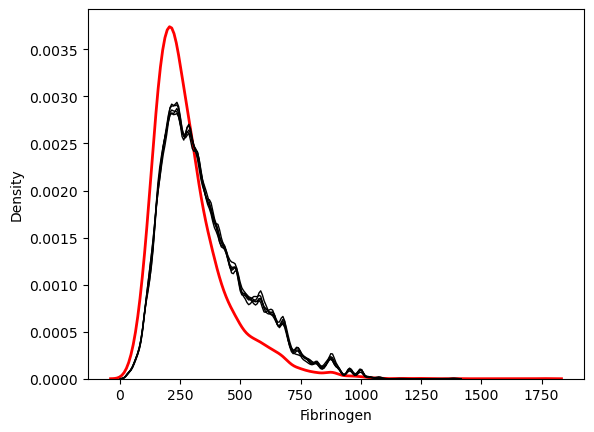

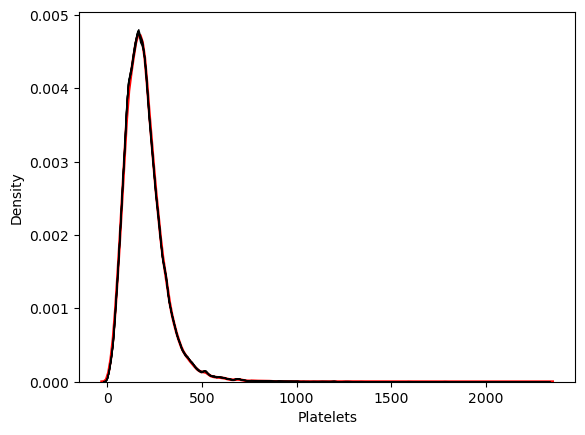

In [694]:
for feature in HospAB_df_mice.columns:
    if feature not in ['Age','Gender','SepsisLabel','patient_id','HospAdmTime','Unit1','Unit2']:
        kernel_hosp12.plot_imputed_distributions(wspace=0.3,hspace=0.3,variables=[feature])

In [695]:
X,y=HospAB_df_complete.drop("SepsisLabel",axis=1),HospAB_df_complete['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  22.1s
0.6510330432093595
[[297069 160219]
 [  2282   6093]]
              precision    recall  f1-score   support

         0.0       0.99      0.65      0.79    457288
         1.0       0.04      0.73      0.07      8375

    accuracy                           0.65    465663
   macro avg       0.51      0.69      0.43    465663
weighted avg       0.98      0.65      0.77    465663



In [696]:
df=feature_imp_XGboost(X.columns,X_test,pipe,y_test)
df
# After shuffling corresponding feature records

,accuracy_score,precision_score,recall_score,f1_score
HR,0.647060,0.034511,0.690388,0.065736
O2Sat,0.651482,0.036414,0.721791,0.069331
Temp,0.650803,0.036250,0.719761,0.069024
SBP,0.640349,0.035572,0.727522,0.067827
MAP,0.645660,0.036104,0.727761,0.068795
DBP,0.655070,0.036429,0.714269,0.069322
Resp,0.645602,0.035548,0.715821,0.067732
EtCO2,0.651772,0.036717,0.727642,0.069907
BaseExcess,0.651222,0.036683,0.728119,0.069847
HCO3,0.653554,0.036739,0.724179,0.069931


### Concatinating both the MICE imputed data and the Nan encoded data of both Hospitals

In [699]:
HospAB_mice_cat=pd.concat([dataset_AB2.drop('SepsisLabel',axis=1),HospAB_df_complete],axis=1)
HospAB_mice_cat.shape

(1552210, 72)

In [700]:
X,y=HospAB_mice_cat.drop("SepsisLabel",axis=1),HospAB_mice_cat['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

classes_weights = class_weight.compute_sample_weight(
    class_weight={0:1,1:100},
    y=y_train)

pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)

xg_pred=pipe.predict(X_test)
print(accuracy_score(y_test,xg_pred))
print(confusion_matrix(y_test,xg_pred))
print(classification_report(y_test,xg_pred))

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.8s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=  31.0s
0.6601447828150401
[[301278 156010]
 [  2248   6127]]
              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79    457288
         1.0       0.04      0.73      0.07      8375

    accuracy                           0.66    465663
   macro avg       0.52      0.70      0.43    465663
weighted avg       0.98      0.66      0.78    465663



### Backward Feature Elimination on Hospital 1

In [780]:
HospA_df=HospA_df.drop(['patient_id','HospAdmTime','Unit2',"EtCO2"],axis=1)

In [783]:
HospA_df.isnull().sum()

HR                   61189
O2Sat                95079
Temp                523314
SBP                 120201
MAP                  80858
DBP                 380297
Resp                 77258
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
Age                      0
Gender                   0
Unit1               386165
ICULOS                   0
S

In [755]:
def BackwardFeatureElimination(data,pipe,zero,one):
    
    dropped_feature_f1_score_dict={}
    worst_feature_list=[]
    
    X,y=data.drop('SepsisLabel',axis=1),data['SepsisLabel']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
    
    classes_weights = class_weight.compute_sample_weight(
    class_weight={0:zero,1:one},
    y=y_train)
    
    pipe.fit(X_train,y_train,XG_Boost__sample_weight=classes_weights)
    xg_pred=pipe.predict(X_test)
    print("F1 Score with all features: ",f1_score(y_test,xg_pred))
    
    while len(worst_feature_list)!=len(data.columns)-2:
        features=[f for f in X.columns if f not in worst_feature_list]
        X_train1=X_train[features]
        X_test1=X_test[features]
        for i,f in enumerate(features):
            X_train_drop=X_train1.drop(X_train1.columns[[i]],axis = 1)
            X_test_drop=X_test1.drop(X_test1.columns[[i]],axis = 1)
            pipe.fit(X_train_drop,y_train,XG_Boost__sample_weight=classes_weights)
            xg_pred=pipe.predict(X_test_drop)
            dropped_feature_f1_score_dict[X.columns[i]]=f1_score(y_test,xg_pred)

        worst_feature=list(dropped_feature_f1_score_dict.keys())[list(dropped_feature_f1_score_dict.values()).index(max(dropped_feature_f1_score_dict.values()))]
        worst_feature_list.append(worst_feature)
        print("----------------------------")
        print("Number of worst features removed: ",len(worst_feature_list))
        print("Feature name: ",worst_feature)
        print("F1 Score after removing the corresponding feature: ",max(dropped_feature_f1_score_dict.values()))
        dropped_feature_f1_score_dict={}


In [756]:
BackwardFeatureElimination(HospA_df,pipe,1,49)

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.3s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
F1 Score with all features:  0.15754601226993864
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.3s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.3s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.3s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   9.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.7s
------

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipel

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipel

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.1s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipel

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.9s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.1s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.8s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipel

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.7s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipel

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
------

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.5s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.2s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
----------------------------
Number of worst features removed:  27
Feature name:  SBP
F1 Score after removing the corresponding feature:  0.1589501494218026
[Pipeline] ............ (step 1 of 2) Processing minmax, total

[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.4s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.1s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
----------------------------
Number of worst features removed:  29
Feature name:  SBP
F1 Score after removing the corresponding feature:  0.1589501494218026
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total

[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.0s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   7.6s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.3s
----------------------------
Number of worst features removed:  31
Feature name:  SBP
F1 Score after removing the corresponding feature:  0.1589501494218026
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing XG_Boost, total=   8.1s
[Pipeline] ............ (step 1 of 2) Processing minmax, total=   0.2s


KeyboardInterrupt: 

In [845]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [846]:
X,y=HospA_df.drop('SepsisLabel',axis=1),HospA_df['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [847]:
X_train.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,ICULOS
662001,81.0,NaN,NaN,125.0,73.67,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.40,1.0,0.0,15.0
39518,109.0,99.0,NaN,152.0,98.00,69.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.27,0.0,NaN,16.0
733193,85.0,98.0,36.17,97.0,67.67,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9,NaN,NaN,NaN,NaN,NaN,86.41,1.0,1.0,28.0
748601,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.79,0.0,NaN,33.0
166349,106.5,98.0,NaN,174.0,105.67,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.12,0.0,NaN,19.0


In [873]:
pipe.named_steps['minmax'].fit(X_train)
X_train1=pipe.named_steps['minmax'].transform(X_train)
X_test1=pipe.named_steps['minmax'].transform(X_test)
X_train1=pd.DataFrame(X_train1,columns=X_train.columns)
X_test1=pd.DataFrame(X_test1,columns=X_train.columns)

In [874]:
classes_weights = class_weight.compute_sample_weight(
class_weight={0:1,1:49},
y=y_train)

In [875]:
X_train1.shape,y_train.shape

((553150, 37), (553150,))

In [876]:
sfs=SequentialFeatureSelector(xgb.XGBClassifier(),k_features=2,forward=False,verbose=1,scoring='f1',cv=0)
sfs1=sfs.fit(X_train1,y_train, {'sample_weights':classes_weights})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  5.6min finished
Features: 36/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.5min finished
Features: 35/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  5.3min finished
Features: 34/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  5.0min finished
Features: 33/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.6min finished
Features: 32/2[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  4.4min finished
Features: 31/2[Parallel(

In [893]:
lst=[]
for key in sfs1.subsets_.keys():
    lst.append(sfs1.subsets_[key]['feature_names'])
    
for i in range(len(lst)-1):
    set1=set(lst[i])
    set2=set(lst[i+1])
    uncommon_elements = set1.symmetric_difference(set2)
    print("Feature dropped after {i+1}")

36

{37: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36),
  'cv_scores': array([0.17284326]),
  'avg_score': 0.17284325637910086,
  'feature_names': ('HR',
   'O2Sat',
   'Temp',
   'SBP',
   'MAP',
   'DBP',
   'Resp',
   'BaseExcess',
   'HCO3',
   'FiO2',
   'pH',
   'PaCO2',
   'SaO2',
   'AST',
   'BUN',
   'Alkalinephos',
   'Calcium',
   'Chloride',
   'Creatinine',
   'Bilirubin_direct',
   'Glucose',
   'Lactate',
   'Magnesium',
   'Phosphate',
   'Potassium',
   'Bilirubin_total',
   'TroponinI',
   'Hct',
   'Hgb',
   'PTT',
   'WBC',
   'Fibrinogen',
   'Platelets',
   'Age',
   'Gender',
   'Unit1',
   'ICULOS')},
 36: {'feature_idx': (0,
   1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   

In [891]:
set1 = set(sfs1.subsets_[37]['feature_names'])
set2 = set(sfs1.subsets_[36]['feature_names'])

# Find the elements that are in only one of the sets
uncommon_elements = set1.symmetric_difference(set2)

print(uncommon_elements)  # Output: {1, 2, 6, 7}

{'MAP'}


In [872]:
metric_dict = sfs1.get_metric_dict()
# Print the scores for each subset of features
for k, v in metric_dict.items():
    print(f'Subset: {k}, Score: {v}')

Subset: 37, Score: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), 'cv_scores': array([0.17284326]), 'avg_score': 0.17284325637910086, 'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36'), 'ci_bound': nan, 'std_dev': 0.0, 'std_err': nan}
Subset: 36, Score: {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), 'cv_scores': array([0.18876168]), 'avg_score': 0.18876167520337453, 'feature_names': ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36'), 'ci_bound':

C:\Users\Admin\anaconda3\envs\env2\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Admin\anaconda3\envs\env2\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [868]:
subsets = sfs.subsets_
print(subsets.values())
# print(subsets['feature_names'][0])

dict_values([{'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), 'cv_scores': array([0.17284326]), 'avg_score': 0.17284325637910086, 'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36')}, {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), 'cv_scores': array([0.18876168]), 'avg_score': 0.18876167520337453, 'feature_names': ('0', '1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36')}, {'feature_idx': (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,